# The Lockdown Model

In [1]:
from matplotlib.pylab import plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib import pyplot, lines
from matplotlib.patches import Patch
import matplotlib

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut

from scipy.stats import ttest_ind

import researchpy as rpy

from loguru import logger



import pandas as pd
import numpy as np

import seaborn as sns

import datetime 


%matplotlib inline

# Parameters

In [2]:
us_peak_model_dataset = '../data/processed/peak_model_ctp_covid.csv'
countries_peak_model_dataset = '../data/processed/peak_model_owid_covid.csv'

lockdown_dataset = '../data/expanded_lockdowns.pkl'

# Load Datasets

## Load Peak Datasets

In [3]:
logger.info('Load US peak dataset @ %s' % us_peak_model_dataset)

us = pd.read_csv(us_peak_model_dataset, parse_dates=['date'])

us['region'] = 'us'

us.shape, us.state.nunique(), us['date'].max(), us.columns

2020-07-28 14:05:07.158 | INFO     | __main__:<module>:1 - Load US peak dataset @ ../data/processed/peak_model_ctp_covid.csv


((7599, 22),
 51,
 Timestamp('2020-07-27 00:00:00'),
 Index(['aggregation', 'date', 'google_mobility_level_rolling_mean_stage',
        'new_deaths_rolling_mean_stage', 'new_cases_rolling_mean_stage',
        'state', 'new_cases', 'new_deaths', 'population',
        'google_mobility_level', 'google_mobility_level_by_pop',
        'new_cases_rolling_mean', 'new_deaths_rolling_mean',
        'google_mobility_level_rolling_mean', 'new_cases_rolling_mean_rel',
        'new_deaths_rolling_mean_rel', 'google_mobility_level_rolling_mean_rel',
        'new_cases_rolling_mean_stage_day', 'new_deaths_rolling_mean_stage_day',
        'google_mobility_level_rolling_mean_stage_day',
        'new_cases_rolling_mean_cummax', 'region'],
       dtype='object'))

In [4]:
logger.info('Load EU peak dataset @ %s' % countries_peak_model_dataset)

countries = pd.read_csv(countries_peak_model_dataset, parse_dates=['date']).rename(columns={'country':'state'})

countries.shape, countries.state.nunique(), countries.date.max(), countries.columns

2020-07-28 14:05:07.574 | INFO     | __main__:<module>:1 - Load EU peak dataset @ ../data/processed/peak_model_owid_covid.csv


((38133, 25),
 207,
 Timestamp('2020-07-28 00:00:00'),
 Index(['aggregation', 'date', 'google_mobility_level_rolling_mean_stage',
        'new_deaths_rolling_mean_stage', 'new_cases_rolling_mean_stage',
        'country_id', 'state', 'country_code', 'continent', 'region',
        'new_cases', 'new_deaths', 'population', 'google_mobility_level',
        'google_mobility_level_by_pop', 'new_cases_rolling_mean',
        'new_deaths_rolling_mean', 'google_mobility_level_rolling_mean',
        'new_cases_rolling_mean_rel', 'new_deaths_rolling_mean_rel',
        'google_mobility_level_rolling_mean_rel',
        'new_cases_rolling_mean_stage_day', 'new_deaths_rolling_mean_stage_day',
        'google_mobility_level_rolling_mean_stage_day',
        'new_cases_rolling_mean_cummax'],
       dtype='object'))

In [5]:
eu_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia','Cyprus', 'Czech Republic', 'Denmark', 
    'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 
    'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'
]

eu = countries[countries['state'].isin(eu_countries)]
eu.shape, eu.columns

((5122, 25),
 Index(['aggregation', 'date', 'google_mobility_level_rolling_mean_stage',
        'new_deaths_rolling_mean_stage', 'new_cases_rolling_mean_stage',
        'country_id', 'state', 'country_code', 'continent', 'region',
        'new_cases', 'new_deaths', 'population', 'google_mobility_level',
        'google_mobility_level_by_pop', 'new_cases_rolling_mean',
        'new_deaths_rolling_mean', 'google_mobility_level_rolling_mean',
        'new_cases_rolling_mean_rel', 'new_deaths_rolling_mean_rel',
        'google_mobility_level_rolling_mean_rel',
        'new_cases_rolling_mean_stage_day', 'new_deaths_rolling_mean_stage_day',
        'google_mobility_level_rolling_mean_stage_day',
        'new_cases_rolling_mean_cummax'],
       dtype='object'))

## Combine Countries and US Datasets

In [6]:
# Rename country as state and combine.
df = pd.concat([countries.rename(columns={'country': 'state'}), us], ignore_index=True, sort=False).sort_values(by=['state', 'date'])
df.shape, df.state.nunique(), df.aggregation.nunique()

((45732, 25), 258, 287)

## Eliminate aggregations without mobility data

In [7]:
with_mobility_data = df.groupby('aggregation').apply(lambda g: g['google_mobility_level_rolling_mean'].any())

df = df[df['aggregation'].isin(with_mobility_data[with_mobility_data].index)]

df.shape, df['state'].nunique()

((35418, 25), 183)

## Load Lockdown Dataset

In [8]:
logger.info('Loaded expanded lockdowns @ %s' % lockdown_dataset)

lockdowns = pd.read_pickle(lockdown_dataset).set_index('aggregation')
lockdowns.shape

2020-07-28 14:05:11.101 | INFO     | __main__:<module>:1 - Loaded expanded lockdowns @ ../data/expanded_lockdowns.pkl


(15534, 67)

In [9]:
current_lockdowns = lockdowns.sort_values(by='rebound_duration_days').groupby('aggregation').last()
current_lockdowns.shape

(195, 67)

# Lockdown Features
The key lockdown features include the following mobility and case/death related features.


Mobility related features:
* lockdown_start_date
* rebound_start_date

* lockdown_min_mobility_date
* lockdown_min_mobility_level

* lockdown_mean_mobility_level
* rebound_mean_mobility_level

Cases/Deaths related features:
* lockdown_entry_level_cases
* lockdown_exit_level_cases

* lockdown_peak_date_cases
* lockdown_peak_value_cases
* lockdown_peak_level_cases

* overall_peak_date_cases
* overall_peak_value_cases




In [10]:
df = df.sort_values(by='date')

In [11]:
df['during_lockdown'] = df['google_mobility_level_rolling_mean_stage'].isin(['D', 'H'])
df['after_lockdown'] = df['google_mobility_level_rolling_mean_stage'].isin(['B', 'N'])

mean_cases_in_lockdown = df[df['during_lockdown']].groupby('aggregation').apply(lambda g: g['new_cases_rolling_mean'].mean())

# Calculate cumulative mean cases/deaths during rebound.
df = df.set_index(['aggregation', 'date']).join(df[df['after_lockdown']].groupby('aggregation').apply(
    lambda g: g.set_index('date')['new_cases_rolling_mean'].expanding().mean()
), rsuffix='_cum').reset_index()

# Calculate the rebound ratio for each day of the rebound
rebound_ratios = pd.DataFrame(df[df['after_lockdown']].groupby('aggregation').apply(
    lambda g: g.set_index('date')['new_cases_rolling_mean_cum']/mean_cases_in_lockdown.loc[g.name])).rename(
    columns={'new_cases_rolling_mean_cum': 'rebound_ratio'})

df = df.set_index(['aggregation', 'date']).join(rebound_ratios).reset_index()

# Visualising Lockdowns

### Some helpers

In [12]:
# Simplify a number of ease of labeling.
def simplify_number(n):
    
    if n < 1:
        label = '<1'
    elif n > 999999:
        label = '{:,}M'.format(int(n/1000000))
    else:
        label = '{:,}k'.format(int(n/1000)) if n>999 else '{:,}'.format(int(n))

    return label


def simplify_date(date): return date.strftime("%b %d")


# A directional arrow following bt a simplified number.
def directional_arrow(n):
    
    return '↑' if n>0 else '↓'


# A standard marker for peaks and other points
def mark_point(ax, x, y, color='r', markersize=6):
    ax.plot(x, y, marker='o', color=color, markersize=markersize)
    ax.plot(x, y, marker='o', markersize=1, c='k')
    

def plot_label(ax, x, y, label, va='bottom', ha='left', xoffset=datetime.timedelta(days=2), yoffset=.025, **kwargs):
        
    # Create some spacing around the label
    if ha=='right': xoffset = -xoffset
    if va == 'top': yoffset = -yoffset
        
    ax.text(x+xoffset, y+yoffset, label, va=va, ha=ha, color='dimgrey', **kwargs)

### The main visualisation code

In [13]:
def plot_lockdown_model(ax, data, features, growth_type='cases', mobility_col='google_mobility_level_rolling_mean_rel', h = 0.4):
    
    # Some setup
    origin_date, end_date = datetime.date(2020, 1, 1), datetime.datetime.today()
    
    # Add the origin date to the features to avoid passing it as additional param
    features = features.append(pd.Series({'origin_date': origin_date}))
    
    growth_col = 'new_{}_rolling_mean'.format(growth_type)
    
    # Init axis
    ax = setup_axis(ax, origin_date, end_date, h)
    
    # Plot the main curves
    plot_growth_curve(ax, data[growth_col])
    plot_mobility_curve(ax, data[mobility_col], h)
    
    # Annotations and highlights.
    highlight_mobility_features(ax, features, growth_type, h)
    highlight_growth_features(ax, features, growth_type)
        
    # Add the title
    plot_title(ax, features)
    
    
def setup_axis(ax, origin_date, end_date, h):
    
    # x-axis date locators and formatters
    locator = mdates.AutoDateLocator(maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    month_fmt = mdates.DateFormatter('%b')
    def m_fmt(x, pos=None): return month_fmt(x)[:3]

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
        
    ax.tick_params(axis = 'x', which = 'major', width=1, length=5)

    ax.set_xlim(origin_date, end_date)
    ax.set_ylim(-h, 1+h)
    
    # Remove the axes spines and the y ticks
    [s.set_visible(False) for s in ax.spines.values()]
    [t.set_visible(False) for t in ax.get_yticklines()]
    [t.set_visible(False) for t in ax.get_yticklabels()]

    ax.spines['bottom'].set_visible(True)


    
    return ax



def plot_growth_curve(ax, growth_data, fill_colour='whitesmoke'):
    
    # Start at the first non-zero
    data = growth_data.loc[growth_data[growth_data>0].index[0]:].ffill()
    
    # The relative growth values
    rel_data = (data/data.max())
    
    # Plot the growth line and fill the area beneath its curve.
    ax.plot(rel_data.index, rel_data, lw=1.5, c='k')
    ax.fill_between(rel_data.index, 0, rel_data, color=fill_colour, alpha=.25)
    


def plot_mobility_curve(ax, mobility_data, h):
    
    mobility_data = mobility_data.ffill()
    
    # The colours mapped to rel mobility values
    transition_colours = ['white', 'skyblue', 'yellow', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("", transition_colours)
    colours = [cmap(v) for v in (1-mobility_data).values]

    # Plot the bars
    ax.bar(mobility_data.index, [h]*len(mobility_data.index), bottom=-h, width=2, color=colours)
    
    # Plot the trace
    ax.plot(mobility_data.index, (mobility_data*h)-h, lw=1, c='k')
    
    
    
def highlight_mobility_features(ax, features, growth_type, h, **kwargs):
    
    lockdown_min_mobility_level = h*(features['lockdown_min_mobility_level']-1)
    rel_lockdown_entry = features['lockdown_entry_value_'+growth_type]/features['overall_peak_value_'+growth_type]
    rel_lockdown_exit = features['lockdown_exit_value_'+growth_type]/features['overall_peak_value_'+growth_type]

    
    # Start and end of lockdown
    ax.axvline(features['lockdown_start_date'], c='k', ls=':', lw=.5)
    ax.axvline(features['rebound_start_date'], c='k', ls=':', lw=.5)
    
    # Mark the crossing points with the growth curve; make sure to normalise the values correctly relative to overall peak.
    mark_point(ax, features['lockdown_start_date'], rel_lockdown_entry)
    mark_point(ax, features['rebound_start_date'], rel_lockdown_exit)

    # Mark the mobility min and add guideline
    mark_point(ax, features['lockdown_min_mobility_date'], lockdown_min_mobility_level)
    ax.plot([features['lockdown_min_mobility_date']]*2, [lockdown_min_mobility_level, ax.get_ylim()[0]], c='k', ls=':', lw=.5)
    
    # Label the crossing points and the min
    plot_label(ax, features['lockdown_start_date'], ax.get_ylim()[1], 'Start: {} {}/d @ {}'.format(
        simplify_number(features['lockdown_entry_value_'+growth_type]), growth_type[0], simplify_date(features['lockdown_start_date'])
    ), va='top', ha='right')
    
    plot_label(ax, features['rebound_start_date'], ax.get_ylim()[1], 'End: {} {}/d @ {}'.format(
        simplify_number(features['lockdown_exit_value_'+growth_type]), growth_type[0], simplify_date(features['rebound_start_date'])
    ), va='top', ha='left')
    
    # If the mobility level is high then plot the label above the min point.
    ypos = lockdown_min_mobility_level if features['lockdown_min_mobility_level']<.35 else ax.get_ylim()[0]
    plot_label(ax, features['lockdown_min_mobility_date'], ypos, '{}% @ {}'.format(
        simplify_number(100*features['lockdown_min_mobility_level']),
        simplify_date(features['lockdown_min_mobility_date'])
    ), va='bottom', ha='left')

    
    # Mark and label mobility levels during/after lockdown
    ax.plot([features['origin_date'], features['lockdown_start_date']], [h*(features['lockdown_mean_mobility_level']-1)]*2, c='k', ls=':', lw=0.5)
    ax.plot([features['lockdown_start_date'], features['rebound_start_date']], [h*(features['lockdown_mean_mobility_level']-1)]*2, c='k', ls='--', lw=1)

    ax.plot([features['origin_date'], features['rebound_start_date']], [h*(features['rebound_mean_mobility_level']-1)]*2, c='k', ls=':', lw=0.5)
    ax.plot([features['rebound_start_date'], features['overall_end_date']], [h*(features['rebound_mean_mobility_level']-1)]*2, c='k', ls='--', lw=1)

    plot_label(ax, features['origin_date'], h*(features['lockdown_mean_mobility_level']-1), 'During: {}% (x{}d)'.format(
        simplify_number(100*features['lockdown_mean_mobility_level']), simplify_number(features['lockdown_duration_days'])
    ), va='top')
    
    plot_label(ax, features['origin_date'], h*(features['rebound_mean_mobility_level']-1), 'After: {}% (x{}d)'.format(
        simplify_number(100*features['rebound_mean_mobility_level']), simplify_number(features['rebound_duration_days'])
    ))
    
    # Mark and label current mobility level and trend (relative to rebound)
    mark_point(ax, features['overall_end_date'], h*(features['current_mobility_level']-1), color='k', markersize=3)
    plot_label(ax, features['overall_end_date'], h*(features['current_mobility_level']-1), '{}%'.format(simplify_number(100*features['current_mobility_level'])), va='center')



    

def highlight_growth_features(ax, features, growth_type):
    
    # Mark and label the overall peak; it's a relative peak of 1 by definition.
    mark_point(ax, features['overall_peak_date_'+growth_type], 1)
    
    # Adjust the alignment if the peak is too close to right margin.
    ha = 'center' if features['overall_peak_date_'+growth_type]<(features['overall_end_date']-datetime.timedelta(days=7)) else 'right'
    plot_label(ax, features['overall_peak_date_'+growth_type], 1, '{} {}/d\n{}% @ {}'.format(
        simplify_number(features['overall_peak_value_'+growth_type]), growth_type[0],
        100, simplify_date(features['overall_peak_date_'+growth_type]) 
    ), ha=ha)
    ax.axvline(features['overall_peak_date_'+growth_type], c='k', ls=':', lw=.5)


    
    # If there is a separate lockdown peak then mark and label this.
    if features['overall_peak_date_'+growth_type] != features['lockdown_peak_date_'+growth_type]:
        mark_point(ax, features['lockdown_peak_date_'+growth_type], features['lockdown_peak_value_'+growth_type]/features['overall_peak_value_'+growth_type])
        ax.plot([features['lockdown_peak_date_'+growth_type]]*2, [ax.get_ylim()[0], features['lockdown_peak_value_'+growth_type]/features['overall_peak_value_'+growth_type]], c='k', ls=':', lw=.5)

        # if there is sufficient space between the lockdown and overall peaks then label the former.
        if abs((features['overall_peak_date_'+growth_type]-features['lockdown_peak_date_'+growth_type]).days)>10:
            plot_label(ax, features['lockdown_peak_date_'+growth_type], features['lockdown_peak_value_'+growth_type]/features['overall_peak_value_'+growth_type], '{} {}/d\n{}% @ {}'.format(
                simplify_number(features['lockdown_peak_value_'+growth_type]), growth_type[0],
                simplify_number(100*features['lockdown_peak_value_'+growth_type]/features['overall_peak_value_'+growth_type]), simplify_date(features['lockdown_peak_date_'+growth_type])
            ), ha='center')

    
    # Mark and label growth means during/after
    ax.plot([features['origin_date'], features['lockdown_start_date']], [features['lockdown_mean_value_'+growth_type]/features['overall_peak_value_'+growth_type]]*2, c='k', ls=':', lw=0.5)
    ax.plot([features['lockdown_start_date'], features['rebound_start_date']], [features['lockdown_mean_value_'+growth_type]/features['overall_peak_value_'+growth_type]]*2, c='k', ls='--', lw=1)

    ax.plot([features['origin_date']+datetime.timedelta(days=30), features['rebound_start_date']], [features['rebound_mean_value_'+'cases']/features['overall_peak_value_'+growth_type]]*2, c='k', ls=':', lw=0.5)
    ax.plot([features['rebound_start_date'], features['overall_end_date']], [features['rebound_mean_value_'+'cases']/features['overall_peak_value_'+growth_type]]*2, c='k', ls='--', lw=1)

    plot_label(ax, features['origin_date'], features['lockdown_mean_value_'+growth_type]/features['overall_peak_value_'+growth_type], 'During:\n{} ({}%)\n{}/day'.format(
        simplify_number(features['lockdown_mean_value_'+growth_type]), simplify_number(100*features['lockdown_mean_value_'+growth_type]/features['overall_peak_value_'+growth_type]), growth_type
    ), rotation=90)


    plot_label(ax, features['origin_date']+datetime.timedelta(days=30), features['rebound_mean_value_'+growth_type]/features['overall_peak_value_'+growth_type], 'After:\n{} ({}%)\n{}/day'.format(
        simplify_number(features['rebound_mean_value_'+growth_type]), simplify_number(100*features['rebound_mean_value_'+growth_type]/features['overall_peak_value_'+growth_type]), growth_type
    ), rotation=90)
    
    # Mark and label current mobility level and trend (relative to rebound)
    mark_point(ax, features['overall_end_date'], features['current_value_'+growth_type]/features['overall_peak_value_'+growth_type], color='k', markersize=3)
    plot_label(ax, features['overall_end_date'], features['current_value_'+growth_type]/features['overall_peak_value_'+growth_type], '{}%'.format(
        simplify_number(100*features['current_value_'+growth_type]/features['overall_peak_value_'+growth_type])
    ), va='center')


def plot_title(ax, features):
    
    title = '{} (p. ~{})\n{} cases/M, {} deaths/M, {:.2f} CFR'.format(
        features['location'].upper(), 
        simplify_number(features['population']),
        simplify_number(1000000*features['total_cases']/features['population']),
        simplify_number(1000000*features['total_deaths']/features['population']),
        features['cfr']
    )
    
    ax.set_title(title, loc='left')
    
    ax.text(features['origin_date']-datetime.timedelta(days=7), .5, 'Confirmed Cases', rotation=90, style='oblique')
    ax.plot([features['origin_date']]*2, [.02, 1.5], c='k', lw=.5)

    ax.text(features['origin_date']-datetime.timedelta(days=7), -.3, 'Mobility', rotation=90, style='oblique')
    ax.plot([features['origin_date']]*2, [-.5, -.02], c='k', lw=.5)

    ax.axhline(0, c='k', lw=.5)








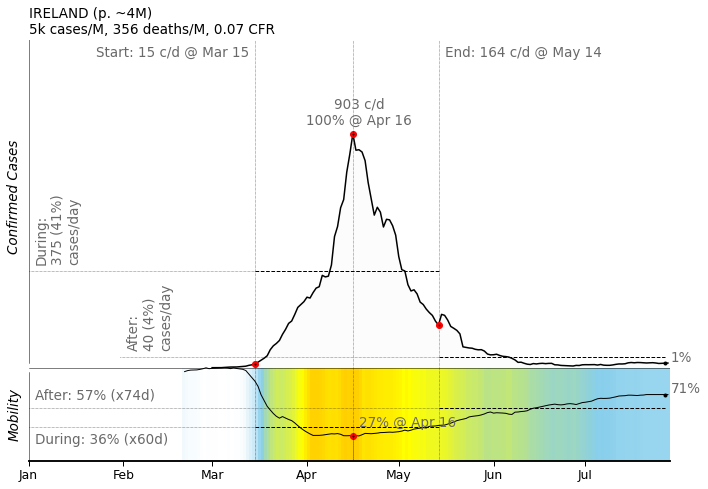

In [14]:
sns.set_context('talk', font_scale=.75)

fig, ax = plt.subplots(figsize=(10, 7))

ireland_data = df[df['aggregation']=='Ireland'].set_index('date')
ireland_features = current_lockdowns.loc['Ireland']

plot_lockdown_model(ax, ireland_data, ireland_features, 'cases', 'google_mobility_level_rolling_mean_rel')
fig.tight_layout()



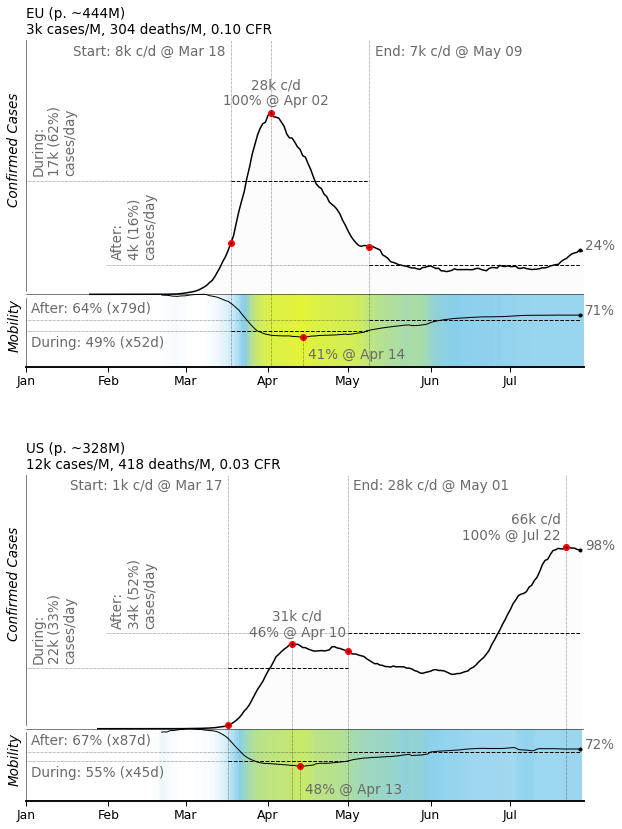

In [15]:
sns.set_context('talk', font_scale=.75)

fig, (ax, bx) = plt.subplots(figsize=(10, 14), nrows=2, gridspec_kw={'hspace': .33})

eu_data = df[df['aggregation']=='eu'].set_index('date')
eu_features = current_lockdowns.loc['eu']


us_data = df[df['aggregation']=='us'].set_index('date')
us_features = current_lockdowns.loc['us']



plot_lockdown_model(ax, eu_data, eu_features);
plot_lockdown_model(bx, us_data, us_features);


fig_params = dict(format='png', dpi=300, bbox_inches = 'tight')
fig.savefig('../graphs/eu_vs_us_cases.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/eu_vs_us_cases.png')

## US States 

In [16]:
# Focus on individual US states
us_states =  df[(df['region']=='us') & (~df['state'].isnull())]

# Get the total cases for each ... to use in sort
total_us_cases = us_states.groupby('state')['new_cases'].sum()

sorted_us_states = sorted(us_states[us_states['state'].notnull()].state.unique(), key=lambda c: total_us_cases.loc[c], reverse=True)
len(sorted_us_states)

51

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


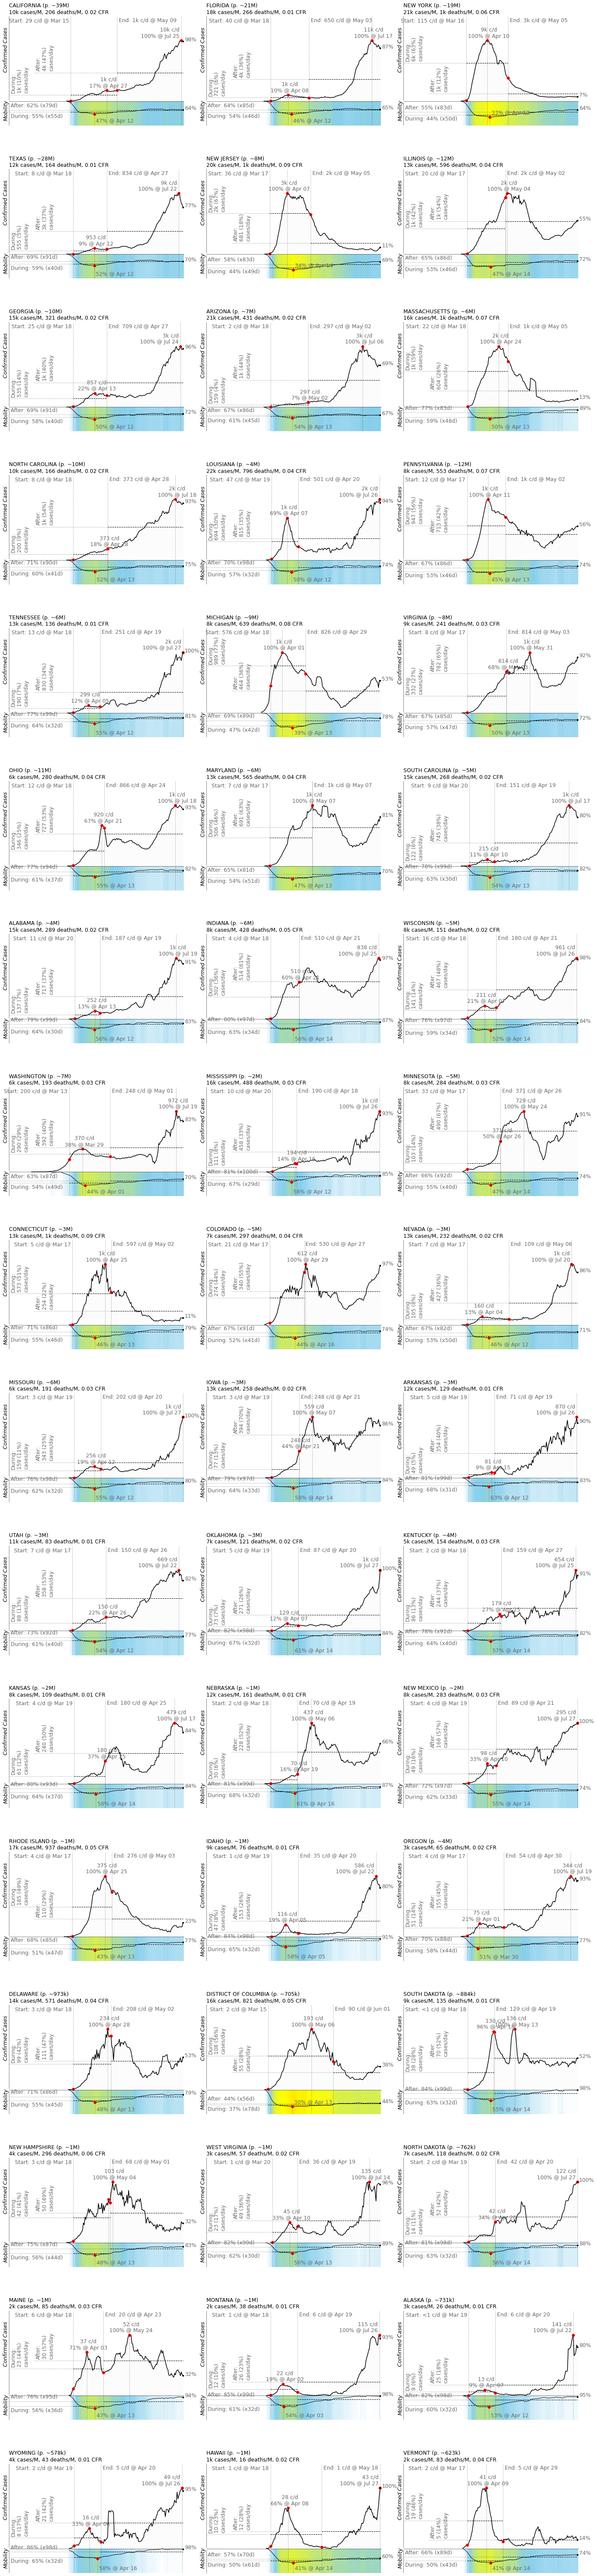

In [17]:
sns.set_context('paper', font_scale=1.3)

w, h = 8, 6.5
ncols, nrows = 3, 17
wspace, hspace = .125, 0.4

fig_format = dict(format='png', dpi=240, bbox_inches = 'tight')

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':wspace})

# 
for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(sorted_us_states, axs.flatten()):
    
    data = df[df['aggregation']==state].set_index('date')
    features = current_lockdowns.loc[state]

    plot_lockdown_model(ax, data, features);


fig.tight_layout()

fig.savefig('../graphs/us_cases.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/us_cases.png')

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


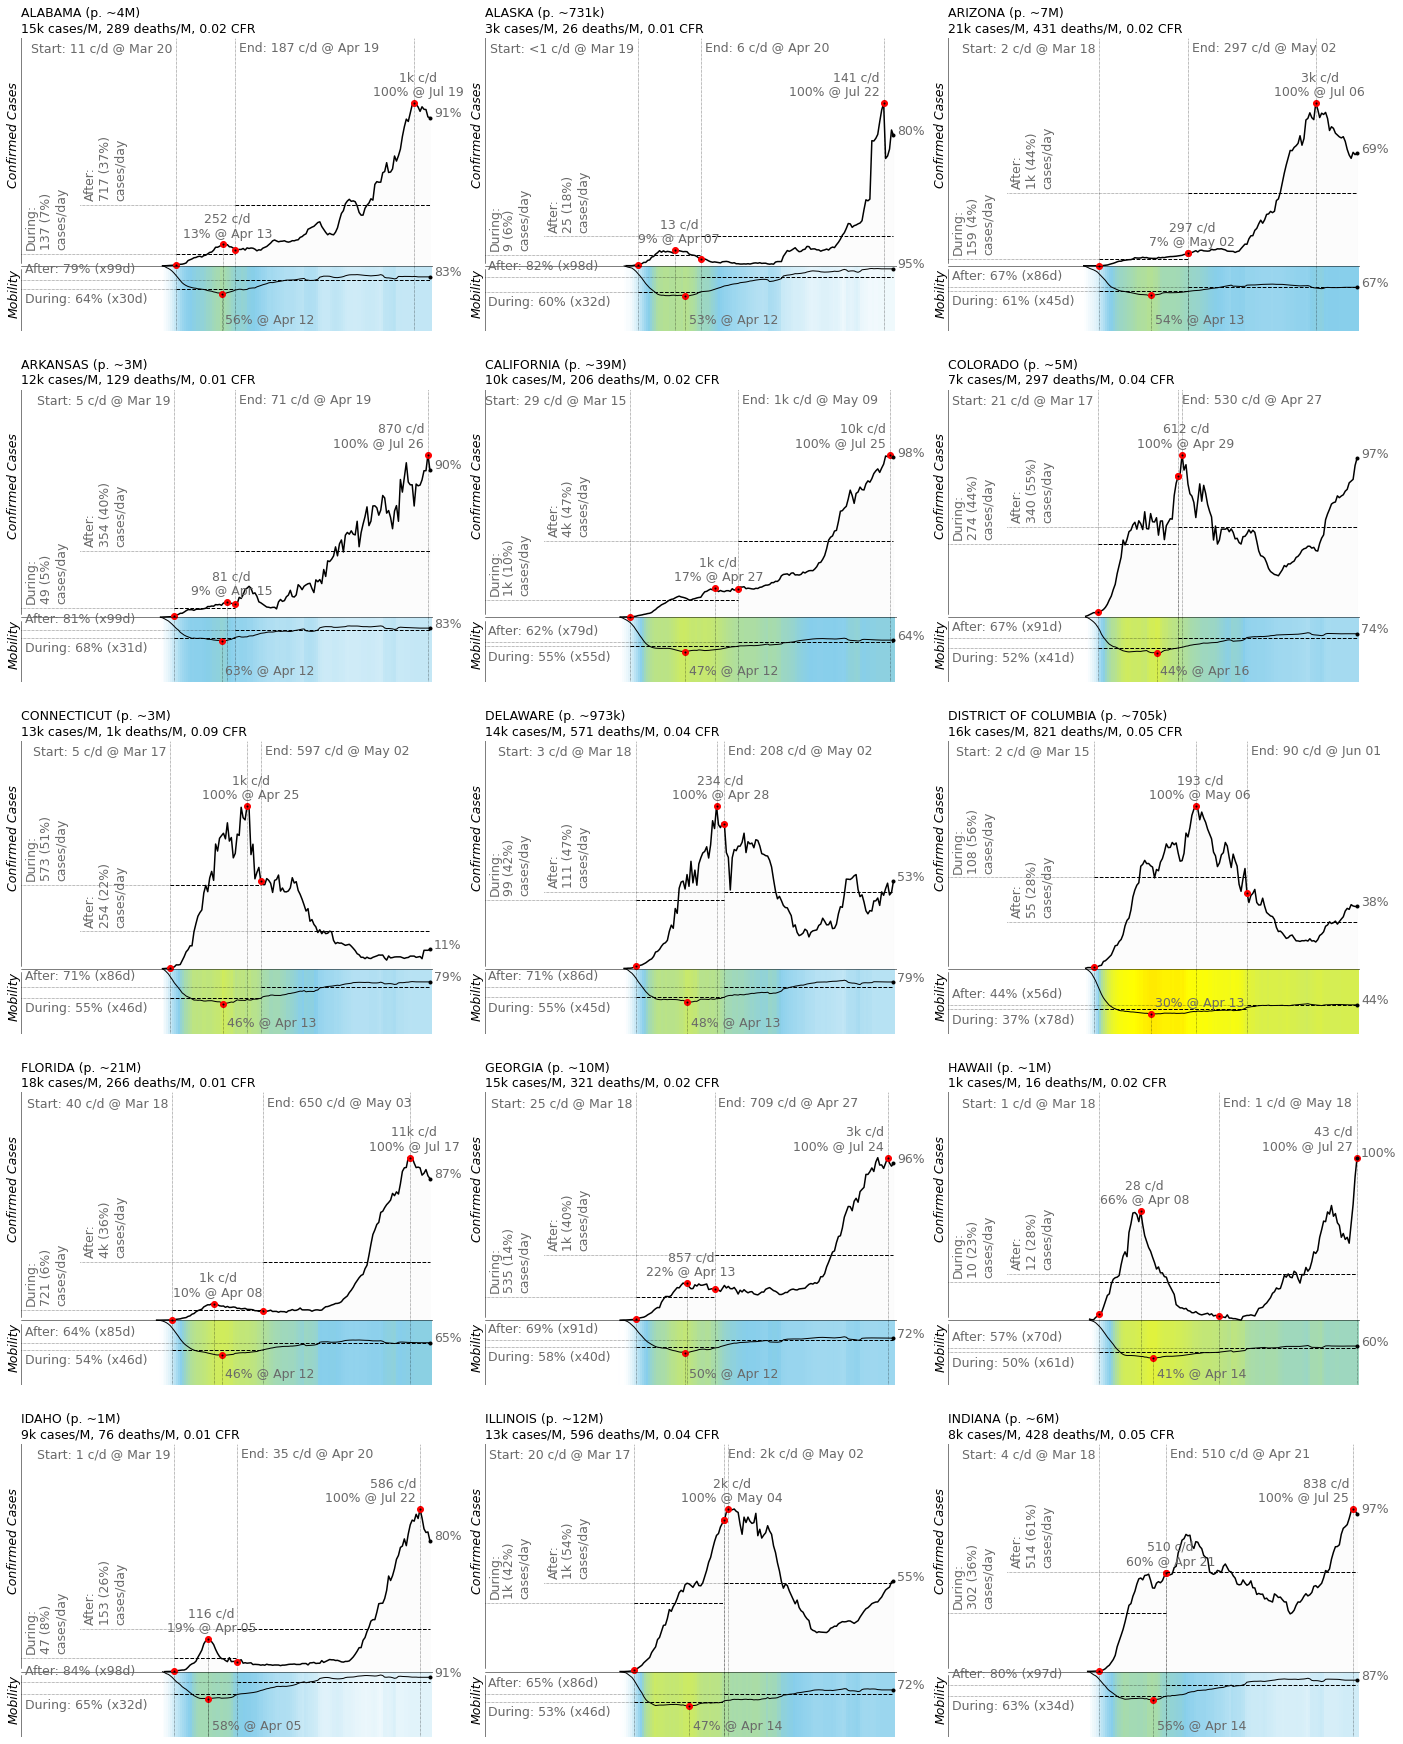

In [18]:
alpha_sorted_us_states = sorted(us_states[us_states['state'].notnull()].state.unique())

sns.set_context('paper', font_scale=1.3)

w, h = 8, 6.25
ncols, nrows = 3, 5
wspace, hspace = .125, 0.2

fig_format = dict(format='png', dpi=300, bbox_inches = 'tight')

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':wspace})

for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(alpha_sorted_us_states[:15], axs.flatten()):
    
    data = df[df['aggregation']==state].set_index('date')
    features = current_lockdowns.loc[state]

    plot_lockdown_model(ax, data, features);


fig.tight_layout()

fig.savefig('../graphs/us_cases_alabama_indiana.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/us_cases_alabama_indiana.png')

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


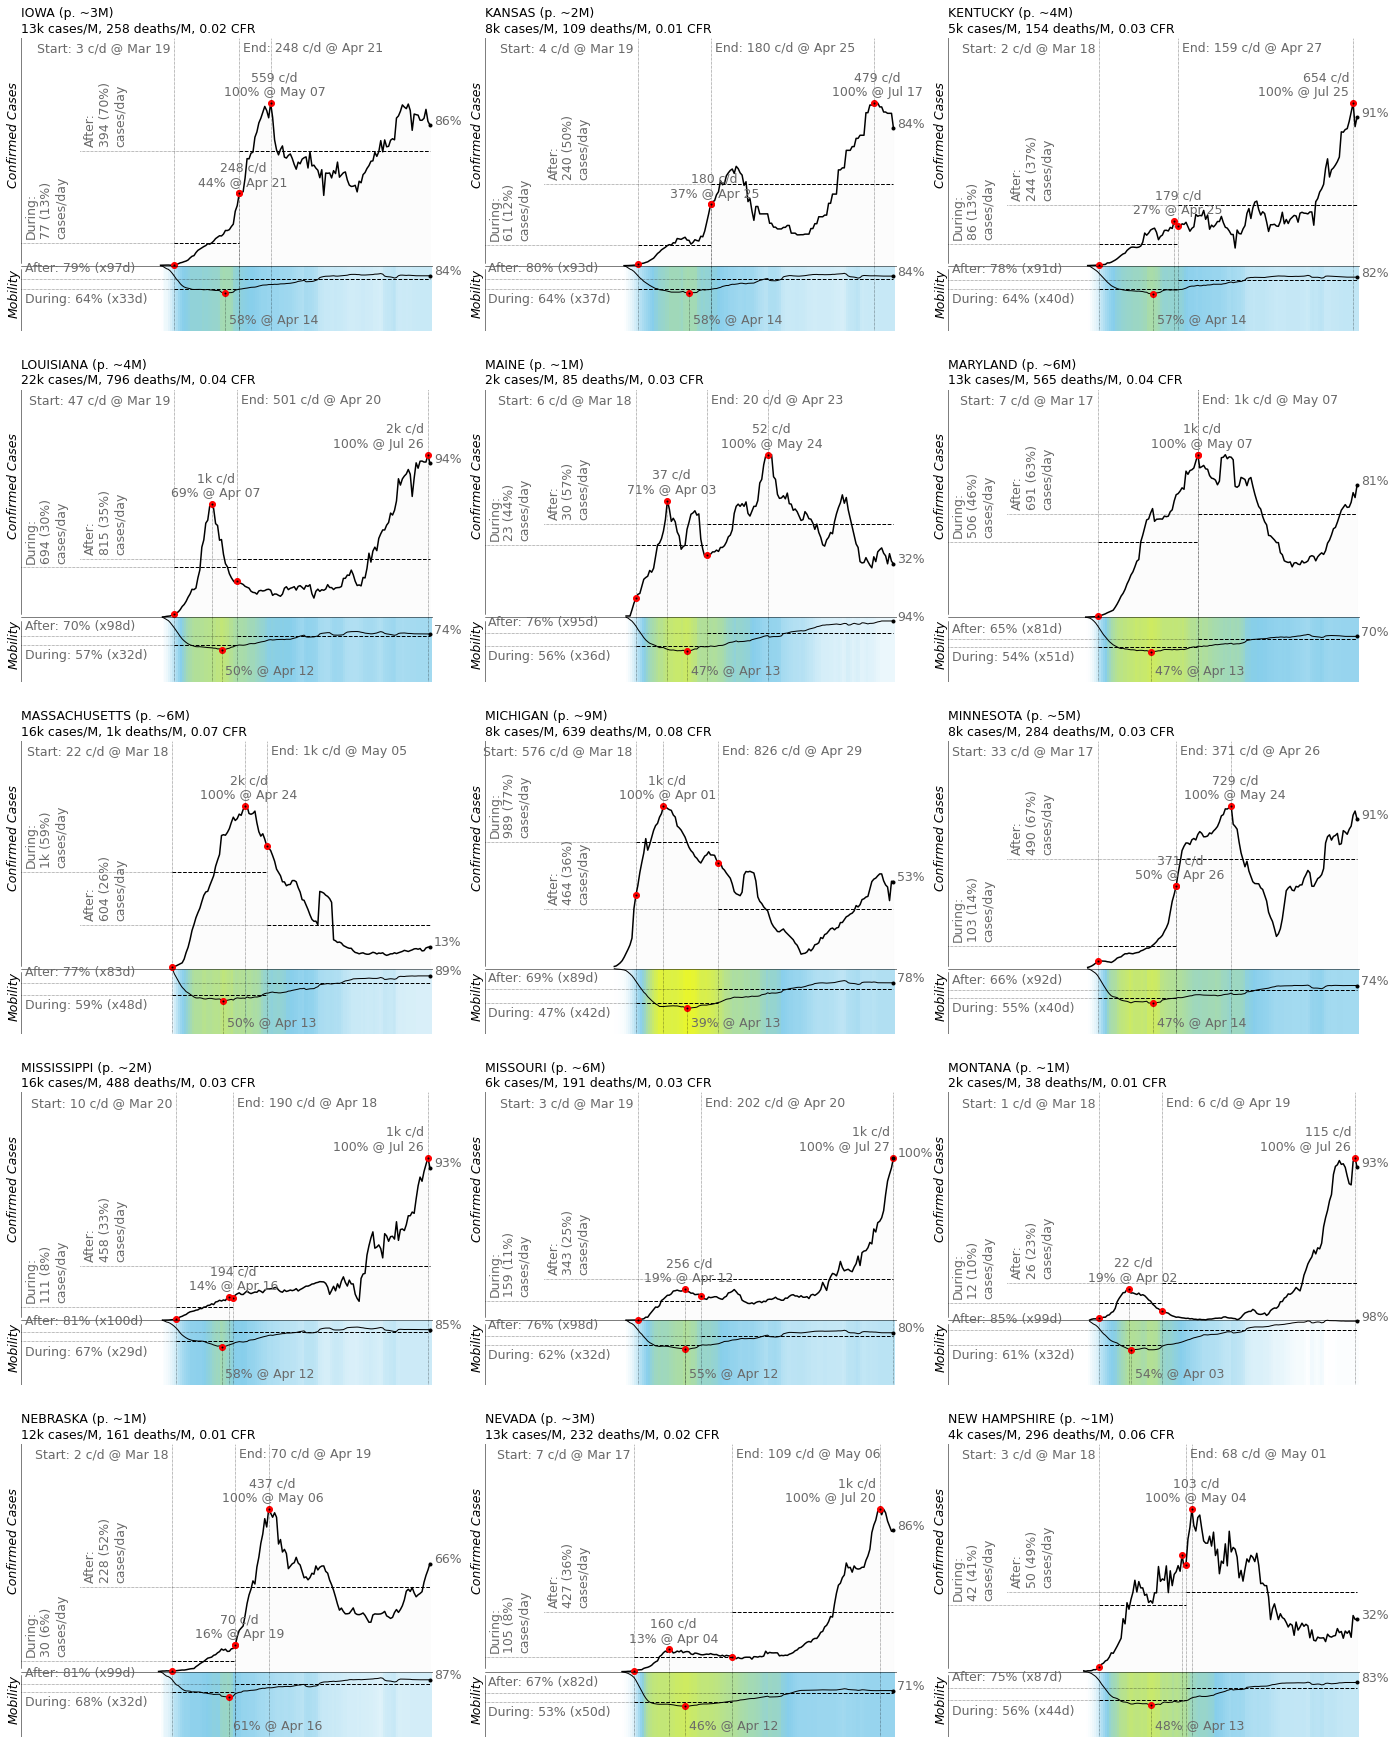

In [19]:
fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':wspace})

for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(alpha_sorted_us_states[15:30], axs.flatten()):
    
    data = df[df['aggregation']==state].set_index('date')
    features = current_lockdowns.loc[state]

    plot_lockdown_model(ax, data, features);


fig.tight_layout()

fig.savefig('../graphs/us_cases_iowa_new_hampshire.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/us_cases_iowa_new_hampshire.png')

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]
2020-07-28 14:14:07.532 | INFO     | __main__:<module>:17 - Saving chart -> ../graphs/us_cases_new_jersey_utah.png


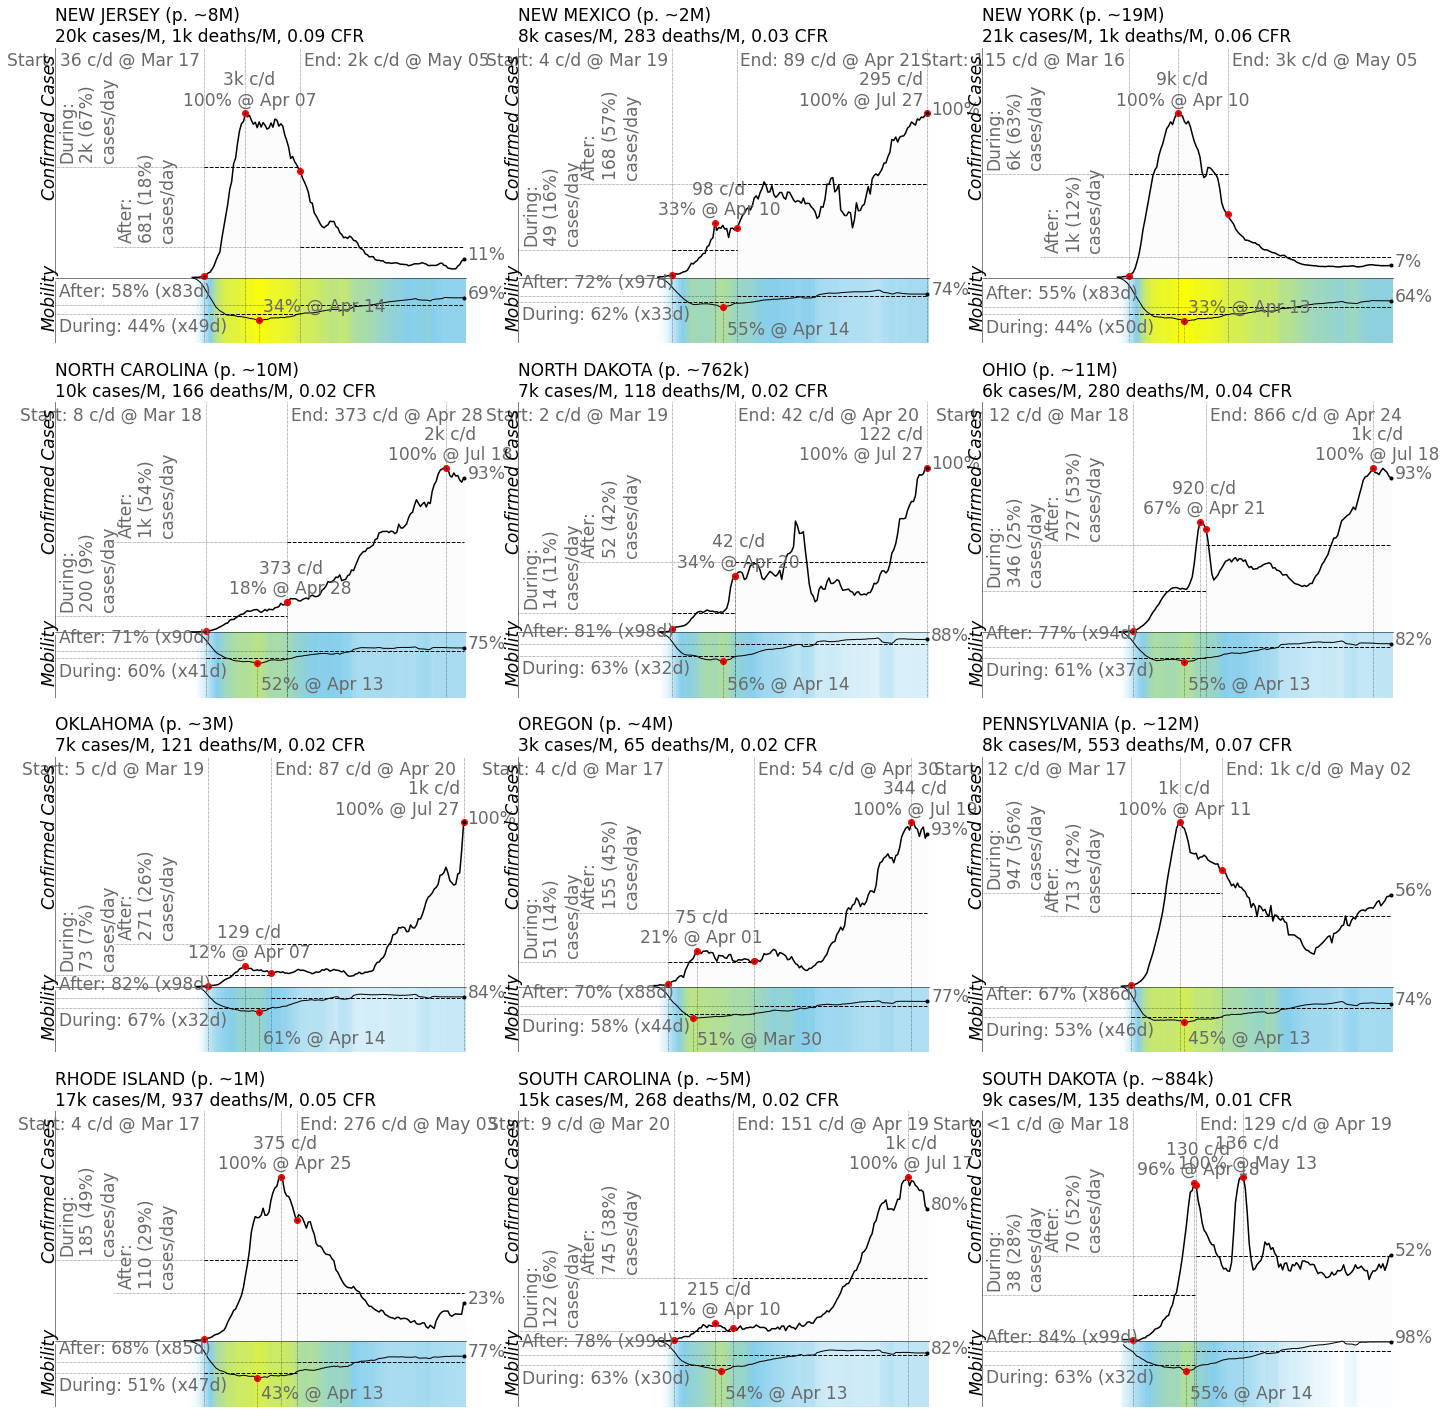

In [48]:
fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':wspace})

for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(alpha_sorted_us_states[30:45], axs.flatten()):
    
    data = df[df['aggregation']==state].set_index('date')
    features = current_lockdowns.loc[state]

    plot_lockdown_model(ax, data, features);


fig.tight_layout()

fig.savefig('../graphs/us_cases_new_jersey_utah.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/us_cases_new_jersey_utah.png')

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app
2020-07-28 14:14:14.012 | INFO     | __main__:<module>:19 - Saving chart -> ../graphs/us_cases_vermont_wyoming.png


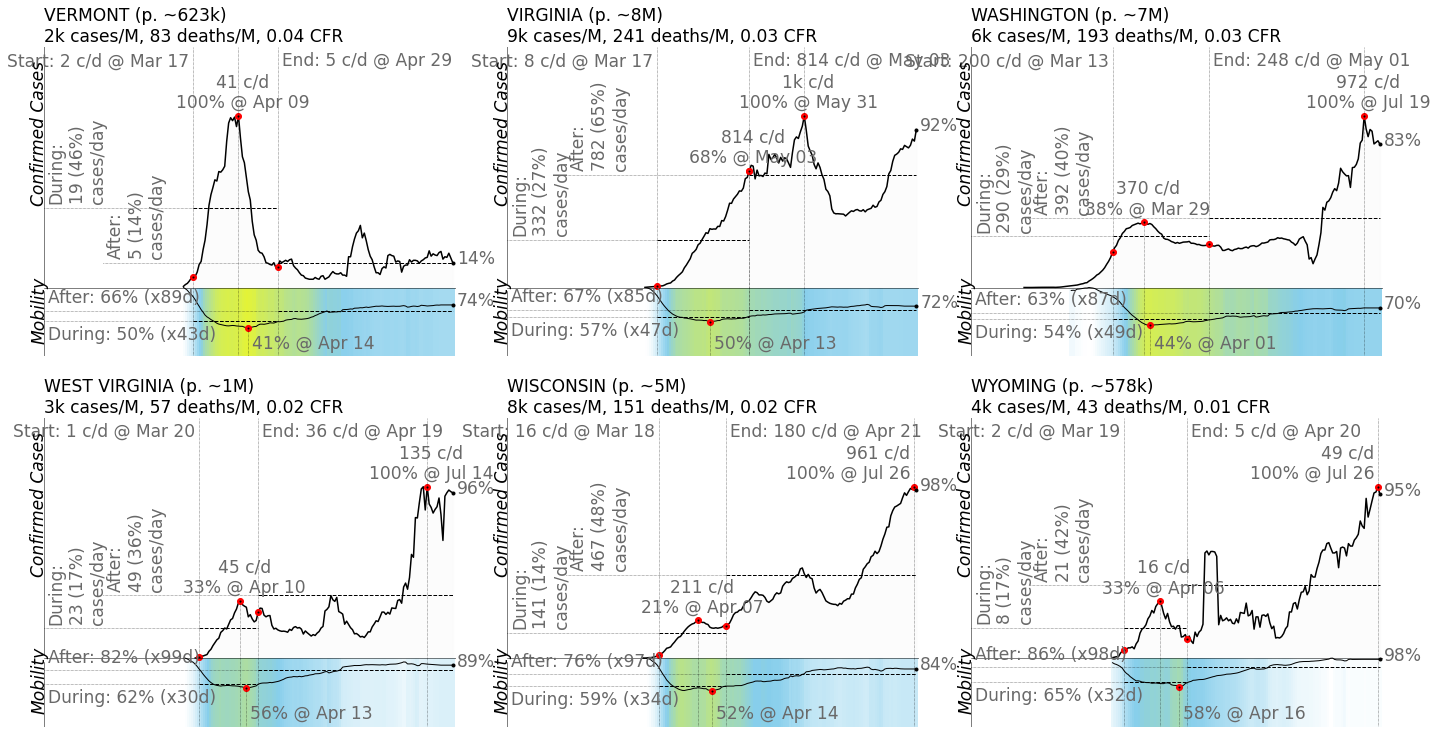

In [49]:
ncols, nrows = 3, 2

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':wspace})

for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(alpha_sorted_us_states[45:], axs.flatten()):
    
    data = df[df['aggregation']==state].set_index('date')
    features = current_lockdowns.loc[state]

    plot_lockdown_model(ax, data, features);


fig.tight_layout()

fig.savefig('../graphs/us_cases_vermont_wyoming.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/us_cases_vermont_wyoming.png')

## EU Countries

In [22]:
# Focus on individual US states
eu_states =  df[(df['region']=='eu') & (~df['state'].isnull())]

# Get the total cases for each ... to use in sort
total_eu_cases = eu_states.groupby('state')['new_cases'].sum()

sorted_eu_states = sorted(eu_states[eu_states['state'].notnull()].state.unique(), key=lambda c: total_eu_cases.loc[c], reverse=True)
len(sorted_eu_states)

26

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


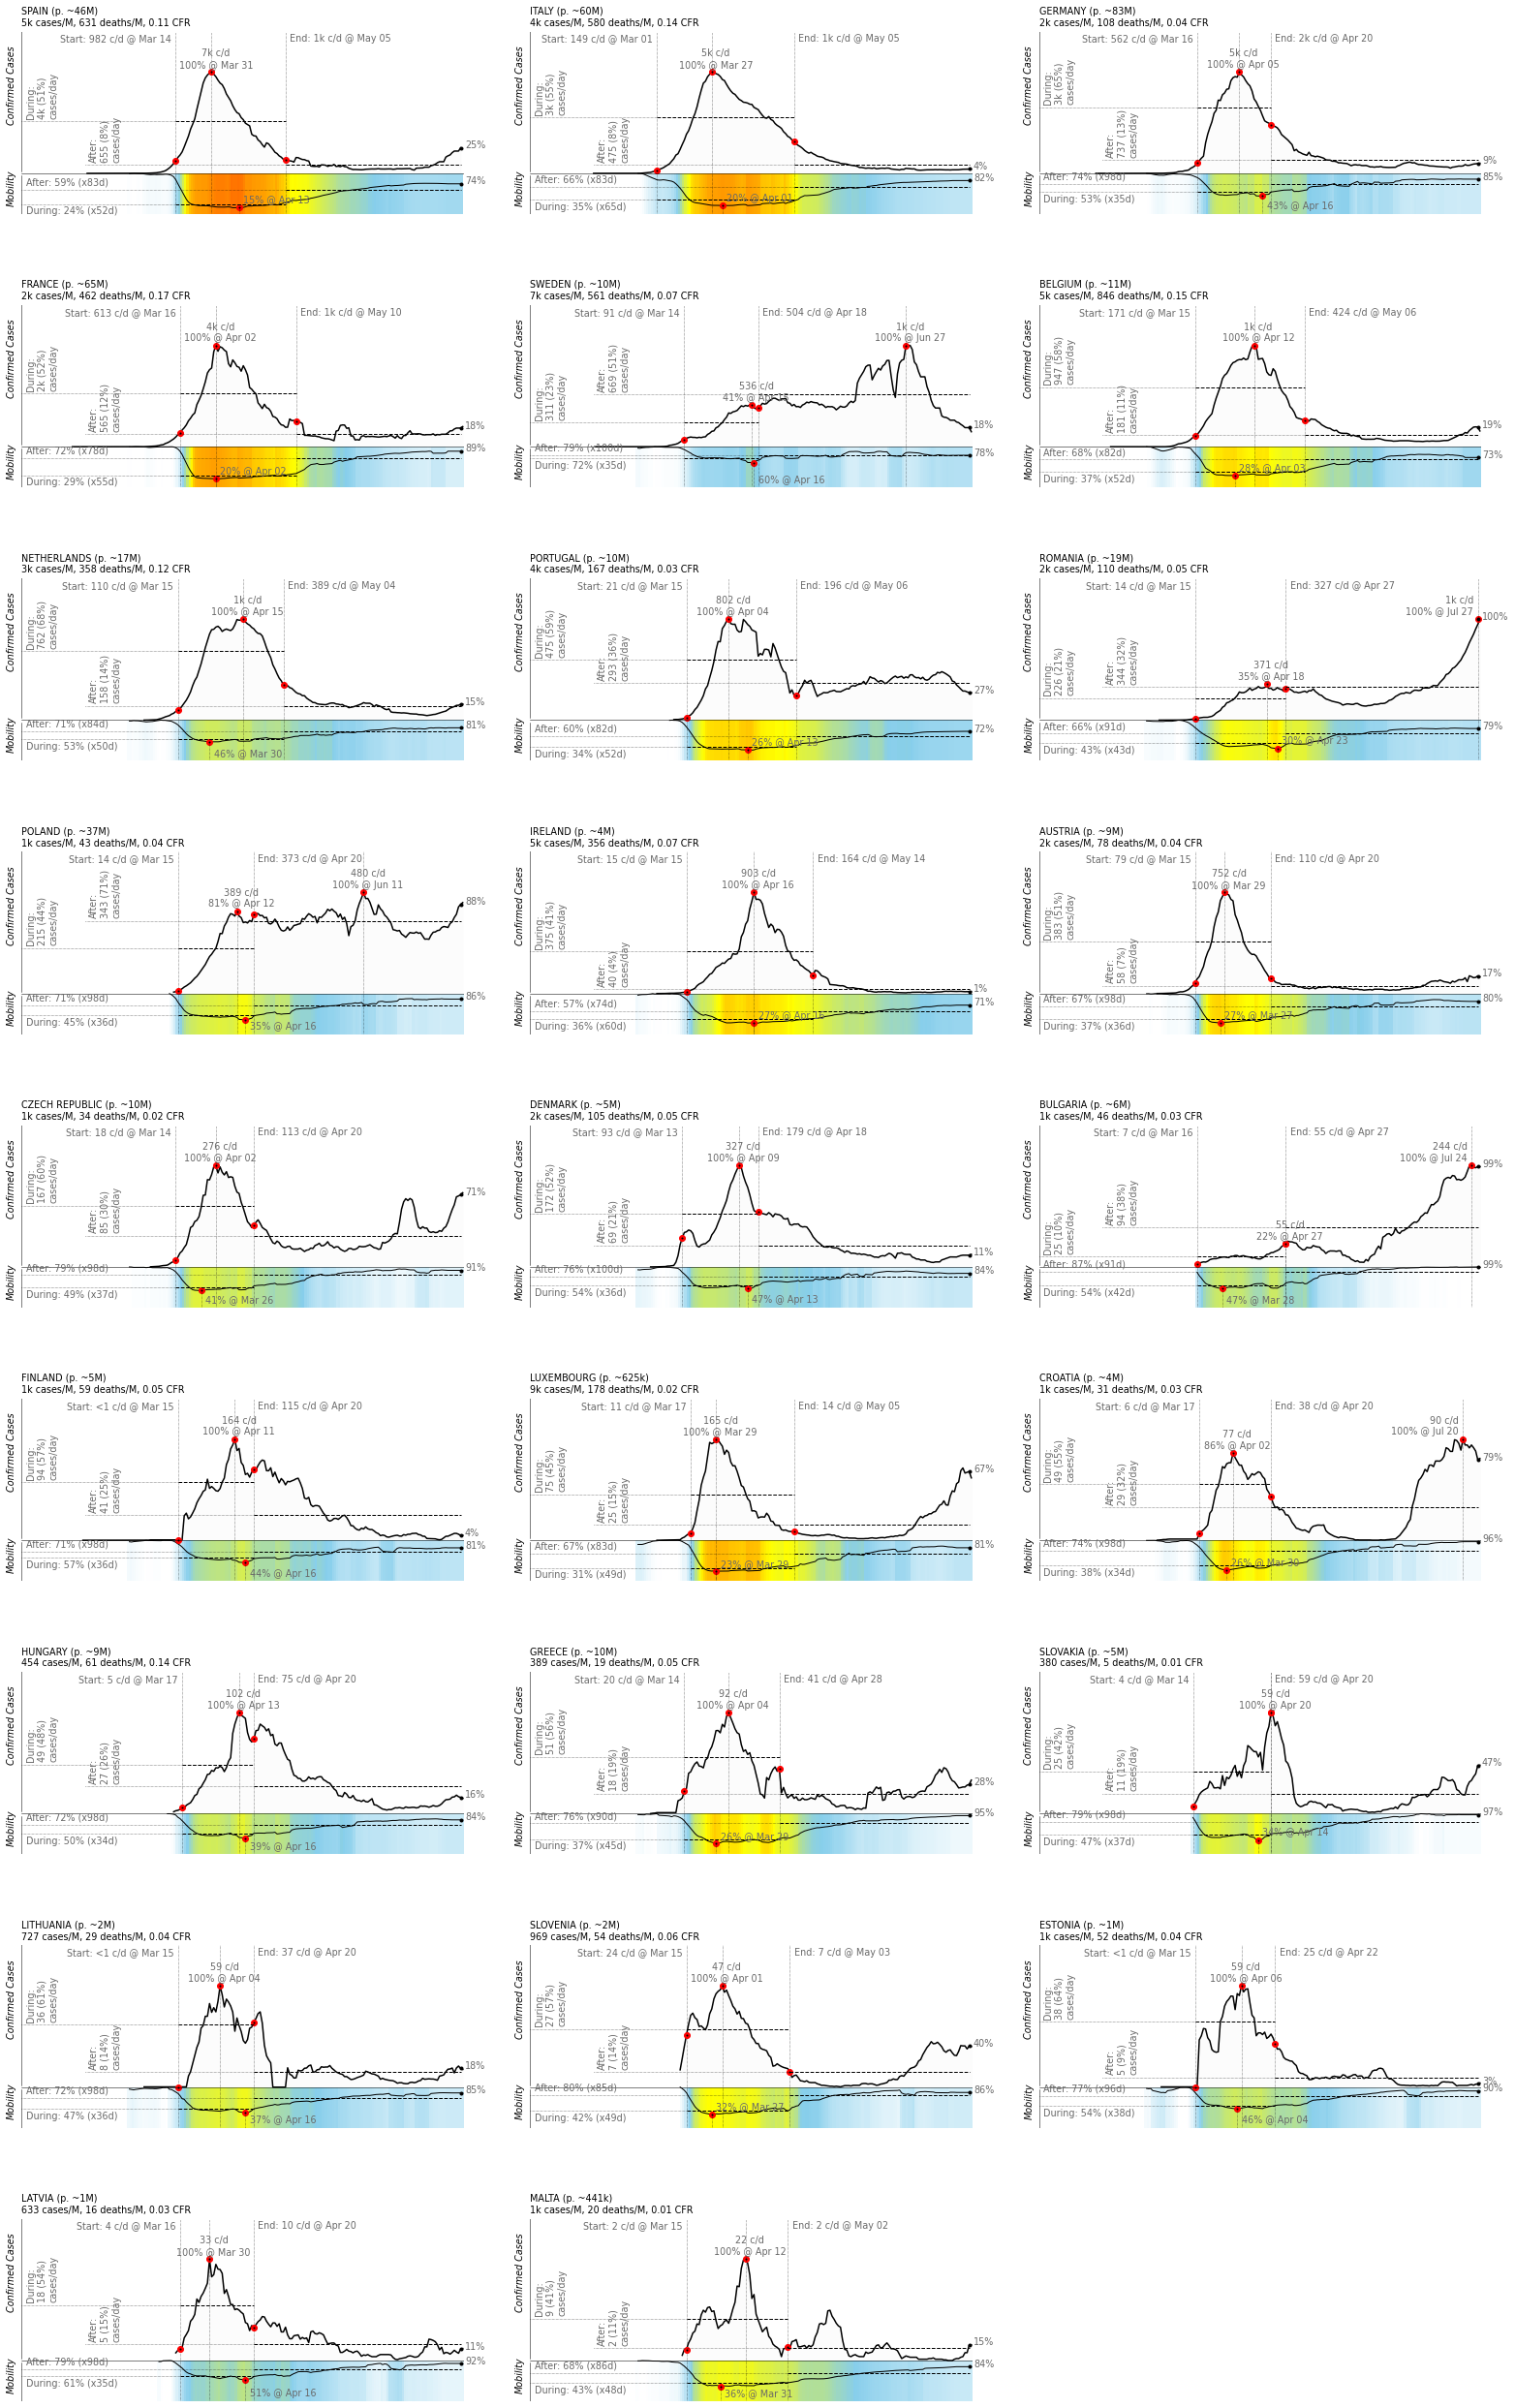

In [23]:
sns.set_context('paper', font_scale=1)

w, h = 9, 5
ncols, nrows = 3, 9
wspace, hspace = .15, 0.5

fig_format = dict(format='png', dpi=240, bbox_inches = 'tight')

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':wspace})


for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(sorted_eu_states, axs.flatten()):
        
    data = df[df['aggregation']==state].set_index('date')
    features = current_lockdowns.loc[state]

    plot_lockdown_model(ax, data, features);


fig.tight_layout()

fig.savefig('../graphs/eu_cases.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/eu_cases.png')

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


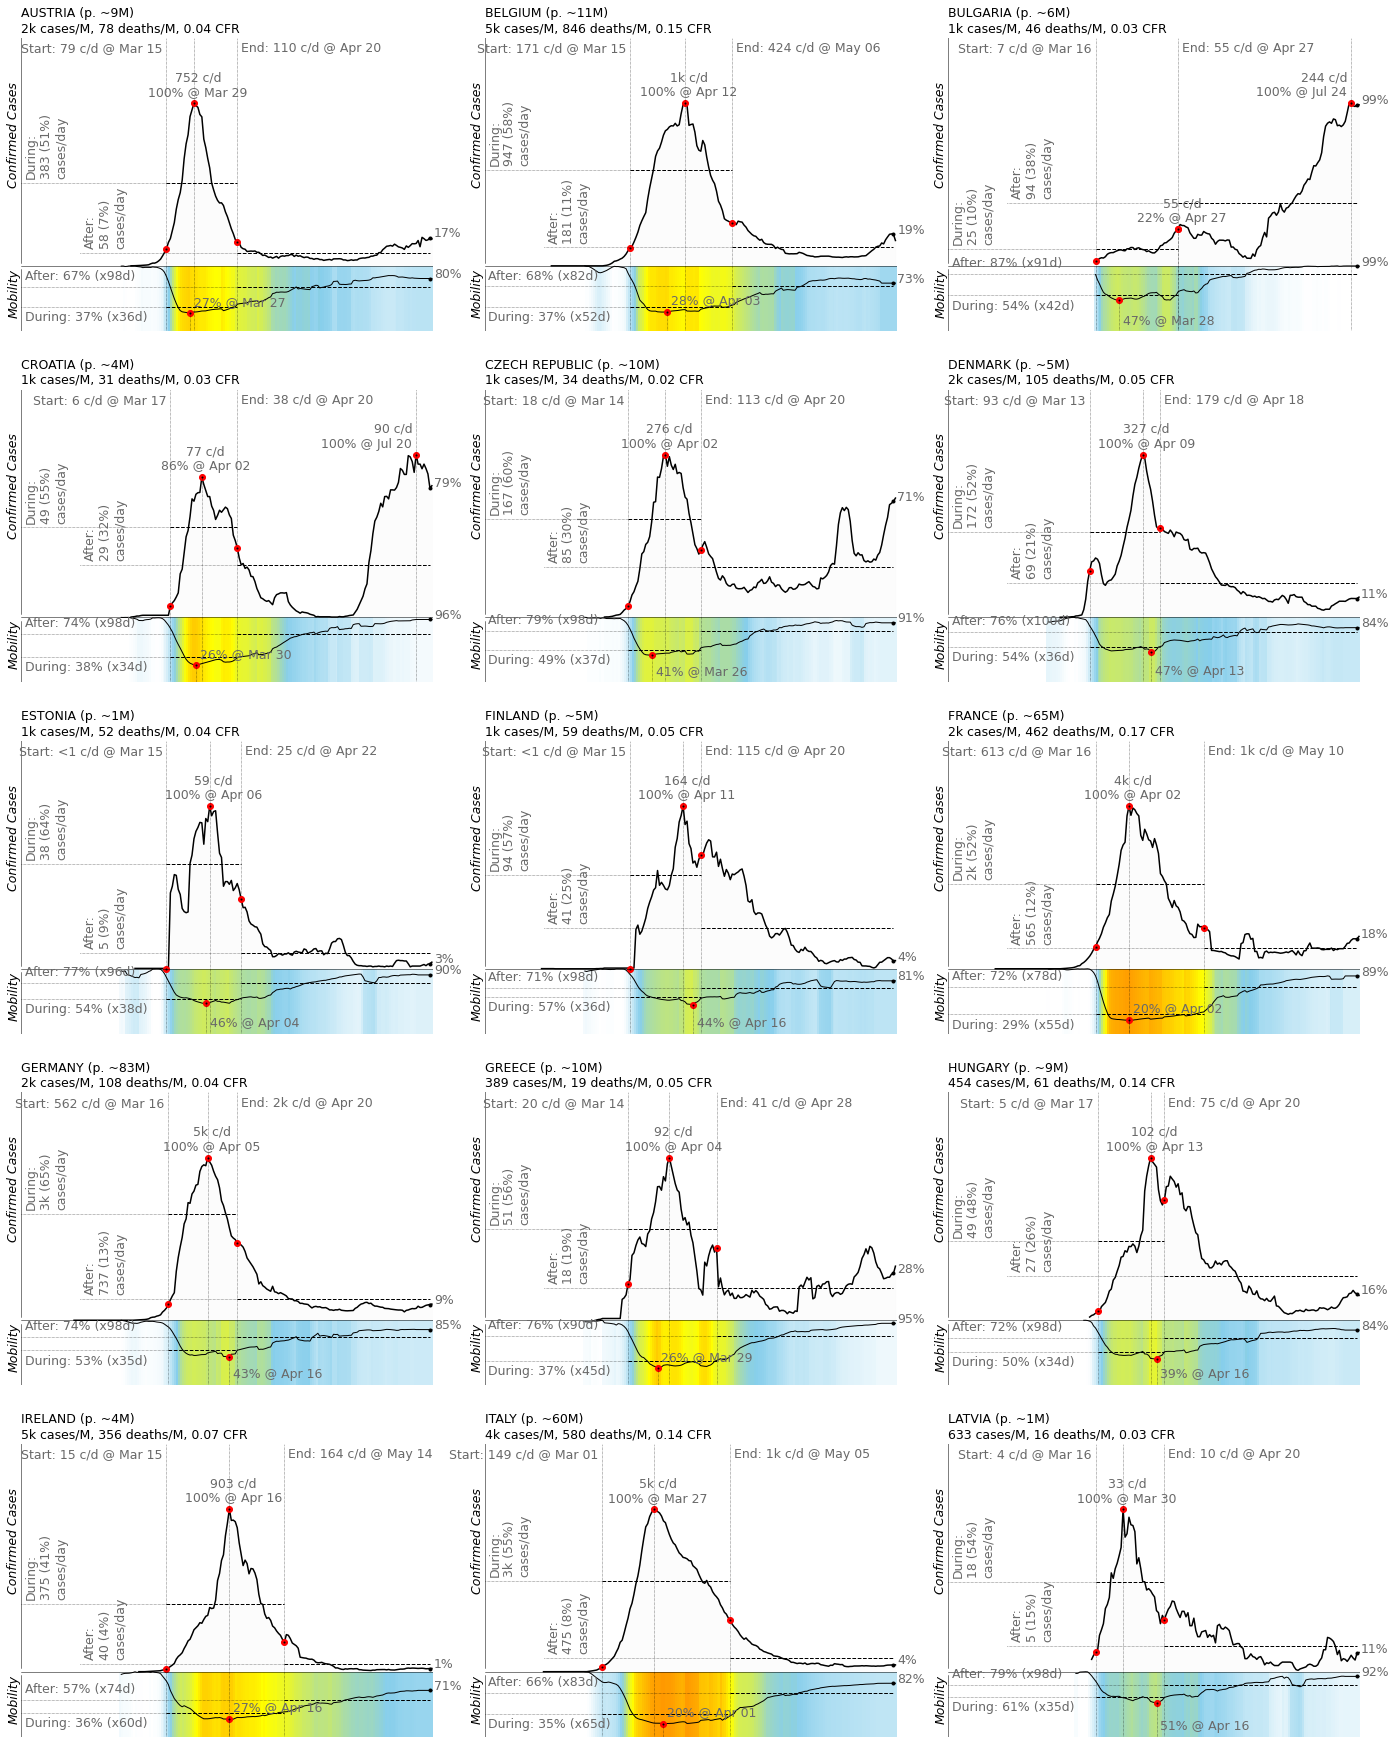

In [24]:
alpha_sorted_eu_states = sorted(eu_states[eu_states['state'].notnull()].state.unique())

sns.set_context('paper', font_scale=1.3)

w, h = 8, 6.25
ncols, nrows = 3, 5
wspace, hspace = .125, 0.2

fig_format = dict(format='png', dpi=300, bbox_inches = 'tight')

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':wspace})

for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(alpha_sorted_eu_states[:15], axs.flatten()):
    
    data = df[df['aggregation']==state].set_index('date')
    features = current_lockdowns.loc[state]

    plot_lockdown_model(ax, data, features);


fig.tight_layout()

fig.savefig('../graphs/eu_cases_austria_latvia.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/eu_cases_austria_latvia.png')

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


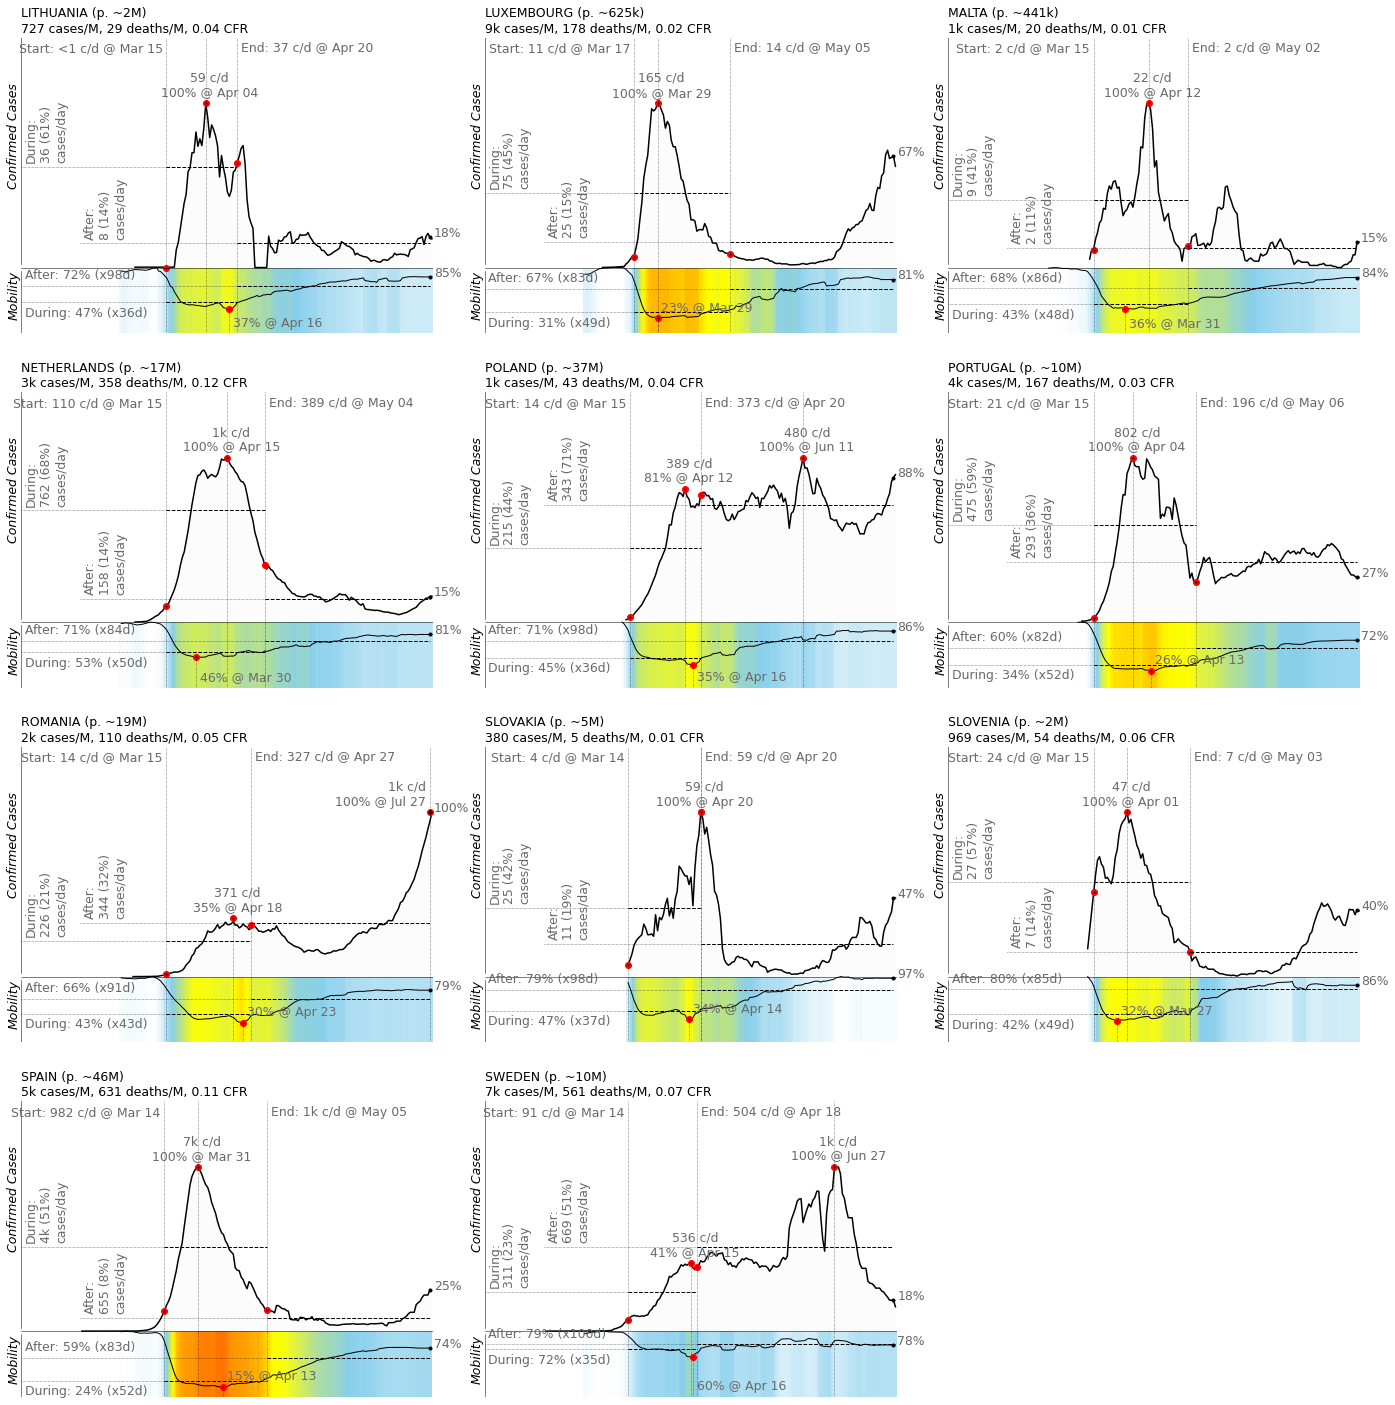

In [25]:
sns.set_context('paper', font_scale=1.3)

w, h = 8, 6.25
ncols, nrows = 3, 4
wspace, hspace = .125, 0.2

fig_format = dict(format='png', dpi=300, bbox_inches = 'tight')

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':wspace})

for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(alpha_sorted_eu_states[15:], axs.flatten()):
    
    data = df[df['aggregation']==state].set_index('date')
    features = current_lockdowns.loc[state]

    plot_lockdown_model(ax, data, features);

fig.tight_layout()

fig.savefig('../graphs/eu_cases_lithuania_sweden.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/eu_cases_lithuania_sweden.png')

# Comparing EU/US During/After Lockdown

## Some Additional Features

In [26]:
eu_us_features = pd.concat([current_lockdowns.loc[sorted_eu_states], current_lockdowns.loc[sorted_us_states]])


eu_us_features = eu_us_features.sort_values(by='rebound_ratio_cases')

eu_us_features.head()

location region  population    total_cases  total_deaths  \
aggregation                                                            
Ireland      Ireland     eu   4937796.0   25829.714286   1759.142857   
Estonia      Estonia     eu   1326539.0    1966.142857     69.000000   
Austria      Austria     eu   9006400.0   20086.857143    711.000000   
Italy          Italy     eu  60461828.0  245331.142857  35087.285714   
Spain          Spain     eu  46754783.0  271422.285714  29545.857143   

                  cfr overall_start_date overall_end_date  \
aggregation                                                 
Ireland      0.068105         2020-03-01       2020-07-27   
Estonia      0.035094         2020-02-28       2020-07-27   
Austria      0.035396         2020-02-26       2020-07-27   
Italy        0.143020         2020-01-31       2020-07-27   
Spain        0.108856         2020-02-01       2020-07-27   

             current_mobility_level  current_value_cases  ...  \
aggregation                                               ...   
Ireland                    0.713208            17.285714  ...   
Estonia                    0.905856             1.857143  ...   
Austria                    0.805543           130.714286  ...   
Italy                      0.822439           240.571429  ...   
Spain                      0.741594          1992.285714  ...   

             rebound_mean_value_cases_per_million  \
aggregation                                         
Ireland                                  8.294042   
Estonia                                  4.382050   
Austria                                  6.458611   
Italy                                    7.872286   
Spain                                   14.019374   

            rebound_mean_value_deaths_per_100k rebound_ratio_cases  \
aggregation                                                          
Ireland                               8.671692            0.109186   
Estonia                               2.498002            0.150691   
Austria                               3.521626            0.151498   
Italy                                14.006701            0.151941   
Spain                                12.209090            0.161867   

             rebound_ratio_deaths  rebound_ratio_mobility_level  \
aggregation                                                       
Ireland                  0.179516                      1.550322   
Estonia                  0.317869                      1.435351   
Austria                  0.285333                      1.833436   
Italy                    0.197757                      1.883216   
Spain                    0.121129                      2.415357   

            is_increasing_rebound  is_strong_lockdown  \
aggregation                                             
Ireland                     False                True   
Estonia                     False               False   
Austria                     False                True   
Italy                       False                True   
Spain                       False                True   

             is_conservative_rebound is_successful_rebound  \
aggregation                                                  
Ireland                         True                  True   
Estonia                        False                  True   
Austria                         True                  True   
Italy                           True                  True   
Spain                           True                  True   

             is_successful_rebound_deaths  
aggregation                                
Ireland                              True  
Estonia                              True  
Austria                              True  
Italy                                True  
Spain                                True  

[5 rows x 67 columns]

In [27]:
eu_us_features['rebound_mean_value_deaths_per_100k'].tail()

aggregation
South Carolina    24.927168
Texas             15.740617
Arkansas          11.858197
Nebraska          15.139368
Arizona           44.958662
Name: rebound_mean_value_deaths_per_100k, dtype: float64

In [28]:
eu_us_features['overall_end_date']

aggregation
Ireland          2020-07-27
Estonia          2020-07-27
Austria          2020-07-27
Italy            2020-07-27
Spain            2020-07-27
                    ...    
South Carolina   2020-07-27
Texas            2020-07-27
Arkansas         2020-07-27
Nebraska         2020-07-27
Arizona          2020-07-27
Name: overall_end_date, Length: 77, dtype: datetime64[ns]

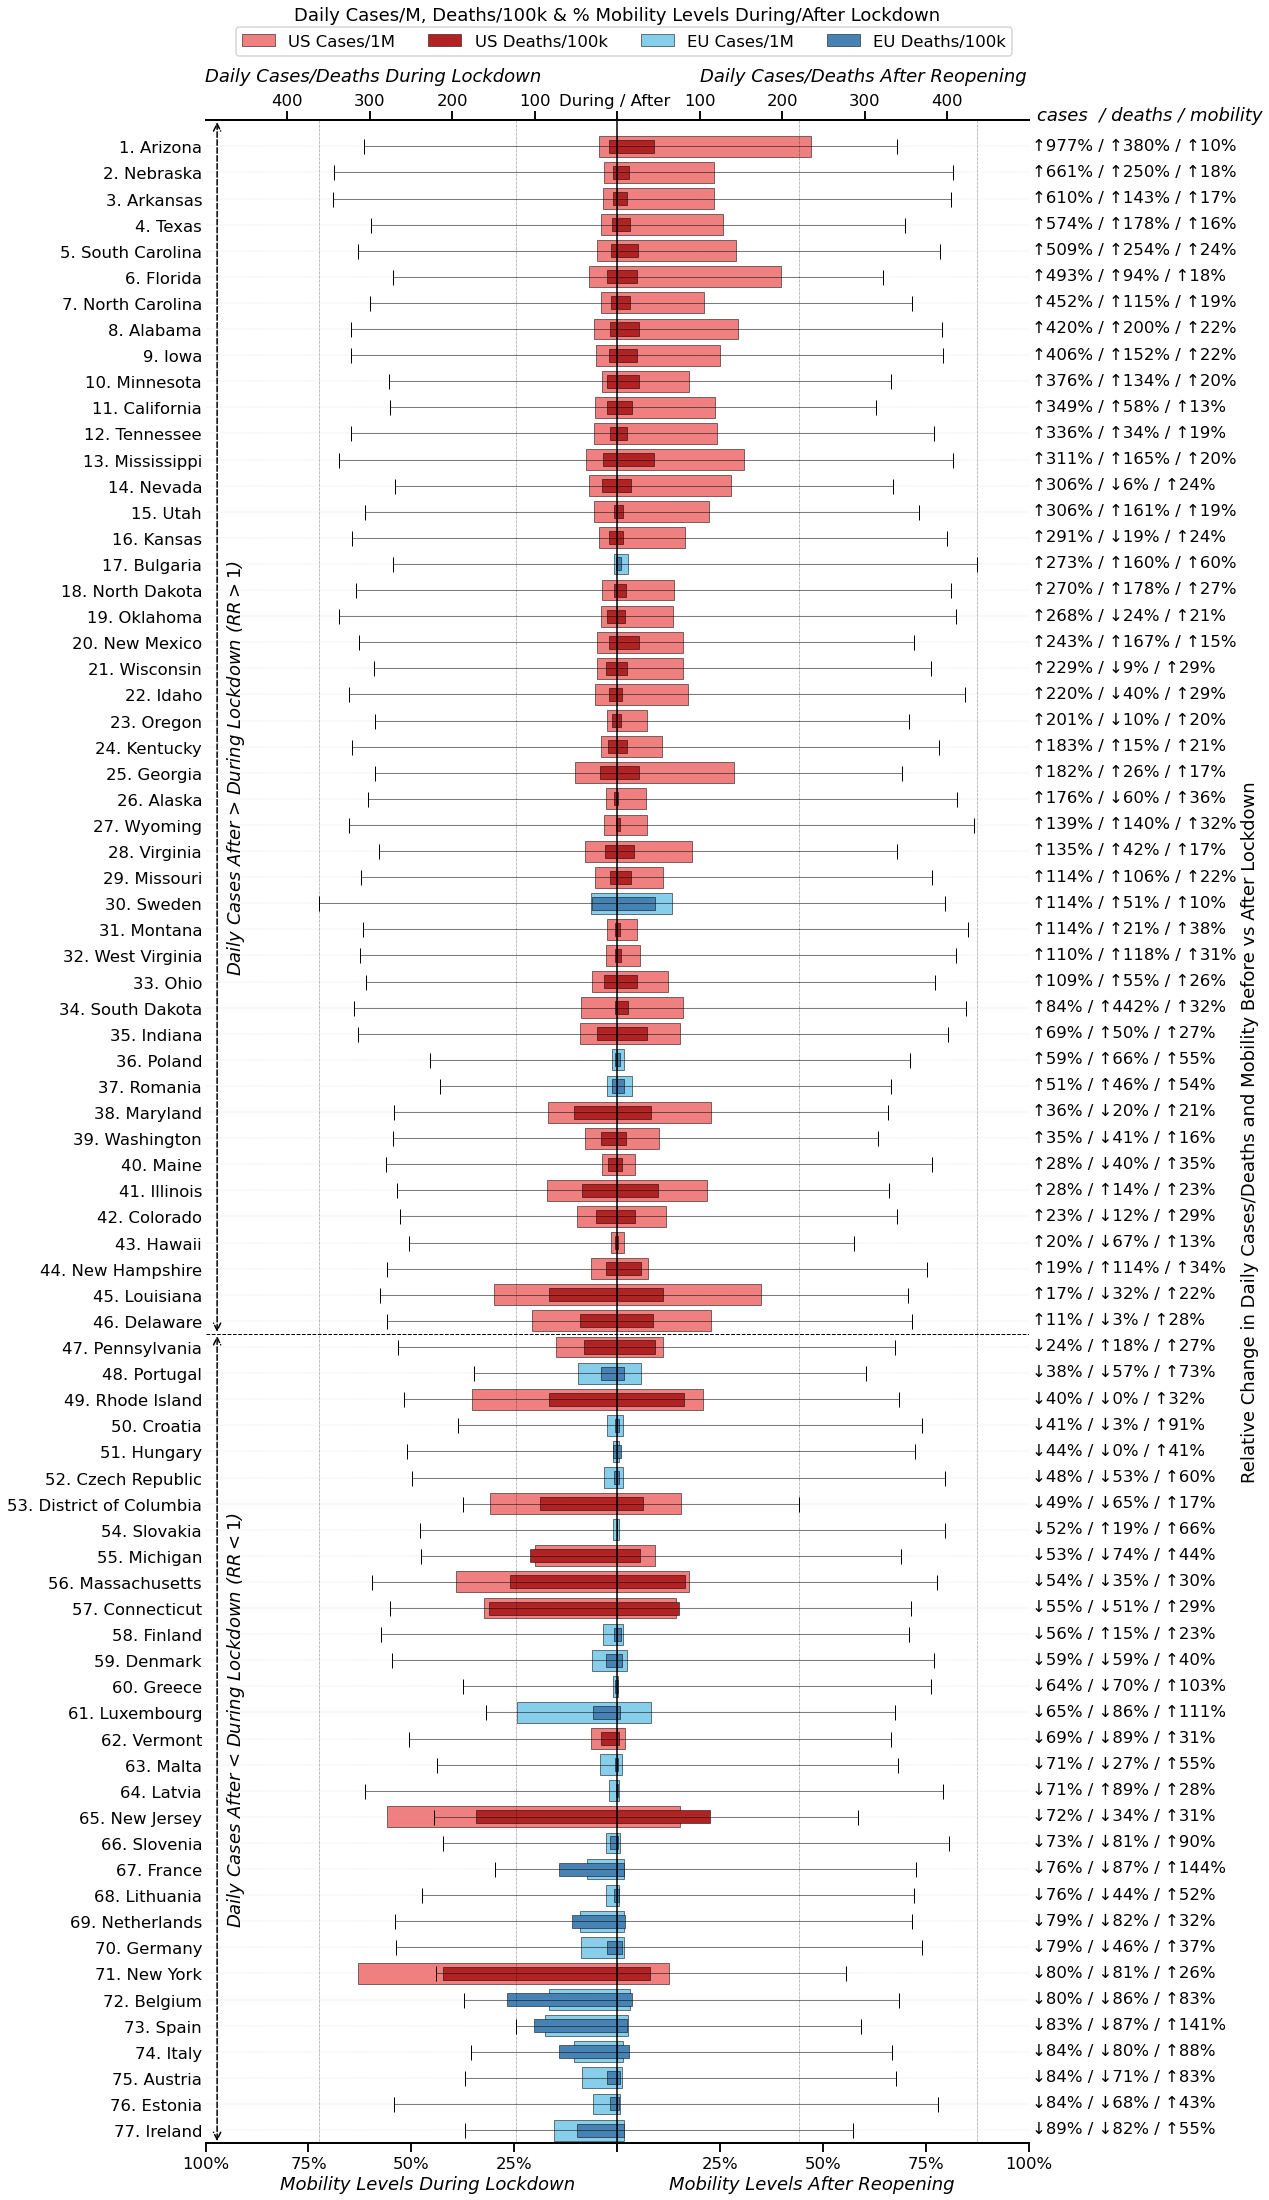

In [29]:
sns.set_context('talk', font_scale=1)


bar_height = .4

fig, ax = plt.subplots(figsize=(18, len(eu_us_features)*bar_height))

# --- THE DAILY CASES/DEATHS BARS (ax)

# Colours for the US and EU barsl; a sequence of colours that match the sorting
bar_colours1 = np.where(eu_us_features['region']=='us', 'lightcoral', 'skyblue')
bar_colours2 = np.where(eu_us_features['region']=='us', 'firebrick', 'steelblue')

w1 = .8
((-eu_us_features['lockdown_mean_value_cases_per_million'])-w1/2).plot(kind='barh', ax=ax, width=w1, color=bar_colours1, edgecolor='k', linewidth=.5)
(eu_us_features['rebound_mean_value_cases_per_million']-w1/2).plot(kind='barh', ax=ax, width=w1, color=bar_colours1, edgecolor='k', linewidth=.5)

w2=.5
((-eu_us_features['lockdown_mean_value_deaths_per_100k'])-w2/2).plot(kind='barh', ax=ax, width=w2, color=bar_colours2, edgecolor='k', linewidth=.5)
(eu_us_features['rebound_mean_value_deaths_per_100k']-w2/2).plot(kind='barh', ax=ax, width=w2, color=bar_colours2, edgecolor='k', linewidth=.5)


# --- THE MOBILITY LEVELS (bx)
bx = ax.twiny()

# Plot the mobility indicators.
bx.plot(-eu_us_features['lockdown_mean_mobility_level']*100, range(len(eu_us_features['lockdown_mean_mobility_level'])), lw=0, marker='|', markersize=15, markerfacecolor='none', c='k')
bx.plot(eu_us_features['rebound_mean_mobility_level']*100, range(len(eu_us_features['rebound_mean_mobility_level'])), lw=0, marker='|', markersize=15, markerfacecolor='none', c='k')

# Connect the indicators
for y, (during, after) in enumerate(zip(eu_us_features['lockdown_mean_mobility_level'].values, eu_us_features['rebound_mean_mobility_level'].values)):
    bx.plot([-during*100, after*100], [y]*2, c='k', lw=.5)
    
# Mark the min/max relative mobility during/after for reference
bx.axvline(-eu_us_features['lockdown_mean_mobility_level'].min()*100, lw=0.5, ls=':', c='k')
bx.axvline(-eu_us_features['lockdown_mean_mobility_level'].max()*100, lw=0.5, ls=':', c='k')

bx.axvline(eu_us_features['rebound_mean_mobility_level'].min()*100, lw=0.5, ls=':', c='k')
bx.axvline(eu_us_features['rebound_mean_mobility_level'].max()*100, lw=0.5, ls=':', c='k')


    
# --- RELATIVE CHANGE INDICATORS (cx)
cx = ax.twinx()

# Add labels to indicate relative change in cases before/after lockdown.
cx_labels = []

def gen_rel_label(v):
    if (v != np.nan) & (v != np.inf):
        if v>0: return '↑{}%'.format(int(abs(v)))
        elif v<0: return '↓{}%'.format(int(abs(v)))
    return '↔0%'

for y, (_, (rel_cases, rel_deaths, rel_mobility)) in enumerate(eu_us_features[['rebound_ratio_cases', 'rebound_ratio_deaths', 'rebound_ratio_mobility_level']].iterrows()):
    
    cx_label = '{} / {} / {}'.format(gen_rel_label((rel_cases-1)*100), gen_rel_label((rel_deaths-1)*100), gen_rel_label((rel_mobility-1)*100))
    cx_labels.append(cx_label)



# --- CONFIGURE THE AXES

# The daily cases/deaths axis
ax.xaxis.tick_top()

ax.set_xlim(-499, 499)
ax.set_xticks(np.arange(-400, 451, 100))
ax.set_xticklabels(['400', '300', '200', '100', 'During / After ', '100', '200', '300', '400'])
ax.set_ylim(-.5, len(eu_us_features))

# Plot the vertical centre line separating the before and after data.
ax.axvline(0, lw=1.5, c='k')

# Add the state labels with a ranking number
state_labels = ['{}. {}'.format((len(eu_us_features)-rank), state) for rank, state in enumerate(eu_us_features.reset_index()['location'])]
ax.set_yticklabels(state_labels)
ax.set_ylabel('')

# Add annotations to separate growers vs decliners
crossing = eu_us_features['rebound_ratio_cases'].index.get_loc(eu_us_features['rebound_ratio_cases'][eu_us_features['rebound_ratio_cases']>1].index[0])-0.5
ax.axhline(crossing, lw=1, c='k', ls='--')
ax.axhline(-.5, lw=1.5, c='k')

ax.annotate(s='', xy=(-485, crossing), xytext=(-485, ax.get_ylim()[1]), arrowprops=dict(arrowstyle='<->', linestyle="dashed"))
ax.text(-475, crossing+14, 'Daily Cases After > During Lockdown ($RR>1$)', rotation=90, style='italic')

ax.annotate(s='', xy=(-485,crossing), xytext=(-485, -.5), arrowprops=dict(arrowstyle='<->', linestyle="dashed"))
ax.text(-475, 8, 'Daily Cases After < During Lockdown ($RR<1$)', rotation=90, style='italic')

# Add the main titles for the bar charts
ax.set_title('Daily Cases/M, Deaths/100k & % Mobility Levels During/After Lockdown', pad=100)
ax.text(-500, ax.get_ylim()[1]+1.5, 'Daily Cases/Deaths During Lockdown', style='italic')
ax.text(100, ax.get_ylim()[1]+1.5, 'Daily Cases/Deaths After Reopening', style='italic')


# The mobility axis
bx.xaxis.tick_bottom()

bx.set_xlim(-100, 100)
bx.set_xticks(np.arange(-100, 101, 25))
bx.set_xticklabels(['100%', '75%', '50%', '25%', '', '25%', '50%', '75%', '100%'])

# Labels
bx.text(-82, ax.get_ylim()[0]-1.75, 'Mobility Levels During Lockdown', style='italic')
bx.text(82, ax.get_ylim()[0]-1.75, 'Mobility Levels After Reopening', style='italic', ha='right')


# The relative change axis (righ-hand y-axis)
cx.set_ylim(*ax.get_ylim())
cx.set_yticks(np.arange(.1, len(cx_labels), 1))

cx.set_yticklabels(cx_labels)
cx.set_ylabel('Relative Change in Daily Cases/Deaths and Mobility Before vs After Lockdown')
cx.text(ax.get_xlim()[1]+10, ax.get_ylim()[1], 'cases  / deaths / mobility', style='italic')



# Build the Legend
legend_elements = [
    Patch(facecolor='lightcoral', edgecolor='k',lw=.5, label='US Cases/1M'),
    Patch(facecolor='firebrick', edgecolor='k',lw=.5, label='US Deaths/100k'),
    Patch(facecolor='skyblue', edgecolor='k',lw=.5, label='EU Cases/1M'),
    Patch(facecolor='steelblue', edgecolor='k',lw=.5, label='EU Deaths/100k')
]

ax.legend(handles=legend_elements, ncol=4, bbox_to_anchor=(.99, 1.05), frameon=True)

    
    
# Remove the frame and the ytick marks
for xx in [ax, bx, cx]:
    xx.spines['right'].set_visible(False)
    xx.spines['left'].set_visible(False)
    xx.tick_params(axis = 'y', which = 'major', width=0, length=0)

# Add gridlines
ax.grid(True, axis='y', ls=':', lw=.33)

fig.tight_layout()

fig.savefig('../graphs/eu_us_ranking.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/eu_us_ranking.png')

In [30]:
(eu_us_features['rebound_ratio_cases']>1).mean(), (eu_us_features.groupby('region')['rebound_ratio_cases'].apply(lambda g: (g>1).mean()))

(0.5974025974025974,
 region
 eu    0.153846
 us    0.823529
 Name: rebound_ratio_cases, dtype: float64)

In [31]:
eu_us_features.loc['Ireland'].filter(like='cases')

total_cases                                          25829.7
current_value_cases                                  17.2857
overall_peak_date_cases                  2020-04-16 00:00:00
overall_peak_value_cases                             903.286
lockdown_days_to_peak_cases                               32
lockdown_days_from_peak_cases                             28
lockdown_entry_value_cases                           15.8571
lockdown_exit_value_cases                            164.714
lockdown_entry_level_cases                          0.017555
lockdown_exit_level_cases                            0.18235
lockdown_entry_exit_ratio_cases                      10.3874
lockdown_peak_date_cases                 2020-04-16 00:00:00
lockdown_peak_value_cases                            903.286
lockdown_peak_level_cases                                  1
lockdown_mean_value_cases                            375.089
lockdown_mean_level_cases                            0.41525
rebound_mean_value_cases

In [32]:
eu_us_features.groupby(eu_us_features['rebound_ratio_cases']>1)['lockdown_mean_mobility_level'].mean()

rebound_ratio_cases
False    0.453322
True     0.598550
Name: lockdown_mean_mobility_level, dtype: float64

# Statistical Comparisons of Key Lockdown Features
Compare key features of lockdowns between increasing and decreasing rebounds.

In [33]:

in_us = eu_us_features['region']=='us'
in_eu = eu_us_features['region']=='eu'

increasing_rebounds = eu_us_features['is_increasing_rebound']
strong_lockdown = eu_us_features['is_strong_lockdown']
conservative_lockdown = eu_us_features['is_conservative_rebound']


## EU vs US

In [34]:
def merge_mean_std(data): return '{:.2f} ± {:.2f}'.format(*data)
def merge_t_p(data): return 'p={:.2f}, t={:.2f}'.format(data[1], data[0])

In [35]:
key_features = [
    'lockdown_mean_value_cases_per_million',
    'lockdown_exit_level_cases', 'lockdown_days_from_peak_cases',
    'lockdown_mean_mobility_level', 'rebound_mean_mobility_level',
    'rebound_ratio_cases'
]

pd.concat({
    'EU': eu_us_features[in_eu][key_features].agg(['mean', 'std']).T.apply(merge_mean_std, axis=1), 
    'US': eu_us_features[in_us][key_features].agg(['mean', 'std']).T.apply(merge_mean_std, axis=1),
    'One-sided $t$ test': pd.DataFrame(ttest_ind(eu_us_features[in_eu][key_features], eu_us_features[in_us][key_features]), columns=key_features).T.apply(merge_t_p, axis=1)
}, axis=1)

EU             US  \
lockdown_mean_value_cases_per_million  33.00 ± 30.03  56.24 ± 67.07   
lockdown_exit_level_cases                0.47 ± 0.30    0.75 ± 0.26   
lockdown_days_from_peak_cases          19.19 ± 11.67  11.14 ± 10.78   
lockdown_mean_mobility_level             0.45 ± 0.11    0.58 ± 0.07   
rebound_mean_mobility_level              0.72 ± 0.07    0.73 ± 0.09   
rebound_ratio_cases                      0.61 ± 0.81    2.95 ± 2.25   

                                      One-sided $t$ test  
lockdown_mean_value_cases_per_million    p=0.10, t=-1.68  
lockdown_exit_level_cases                p=0.00, t=-4.31  
lockdown_days_from_peak_cases             p=0.00, t=3.02  
lockdown_mean_mobility_level             p=0.00, t=-6.60  
rebound_mean_mobility_level              p=0.76, t=-0.30  
rebound_ratio_cases                      p=0.00, t=-5.13

## Successful vs Unsuccessful Reopenings

In [36]:
key_features = [
    'lockdown_mean_value_cases_per_million',
    'lockdown_exit_level_cases', 'lockdown_days_from_peak_cases',
    'lockdown_mean_mobility_level', 'rebound_mean_mobility_level'
]

increasing_rebound = eu_us_features.set_index(eu_us_features['rebound_ratio_cases']>1)[key_features].loc[True]
decreasing_rebound = eu_us_features.set_index(eu_us_features['rebound_ratio_cases']>1)[key_features].loc[False]

pd.concat({
    '$RR\leq1$': decreasing_rebound.agg(['mean', 'std']).T.apply(merge_mean_std, axis=1),
    '$RR>1$': increasing_rebound.agg(['mean', 'std']).T.apply(merge_mean_std, axis=1), 
    'One-sided $t$ test': pd.DataFrame(ttest_ind(increasing_rebound, decreasing_rebound), columns=key_features).T.apply(merge_t_p, axis=1)
}, axis=1)

$RR\leq1$         $RR>1$  \
lockdown_mean_value_cases_per_million  73.77 ± 79.88  31.29 ± 26.65   
lockdown_exit_level_cases                0.43 ± 0.24    0.81 ± 0.24   
lockdown_days_from_peak_cases          21.06 ± 10.02   9.00 ± 10.13   
lockdown_mean_mobility_level             0.45 ± 0.09    0.60 ± 0.06   
rebound_mean_mobility_level              0.69 ± 0.08    0.75 ± 0.07   

                                      One-sided $t$ test  
lockdown_mean_value_cases_per_million    p=0.00, t=-3.35  
lockdown_exit_level_cases                 p=0.00, t=6.69  
lockdown_days_from_peak_cases            p=0.00, t=-5.15  
lockdown_mean_mobility_level              p=0.00, t=8.30  
rebound_mean_mobility_level               p=0.00, t=2.98

# Strong Lockdowns & Conservative Rebounds

In [37]:
# Over-ride for the US/EU features
strong_threshold, conservative_threshold = 0.50, 0.70
eu_us_features['is_strong_lockdown'] = eu_us_features['lockdown_mean_mobility_level'] < strong_threshold
eu_us_features['is_conservative_rebound'] = eu_us_features['rebound_mean_mobility_level'] < conservative_threshold


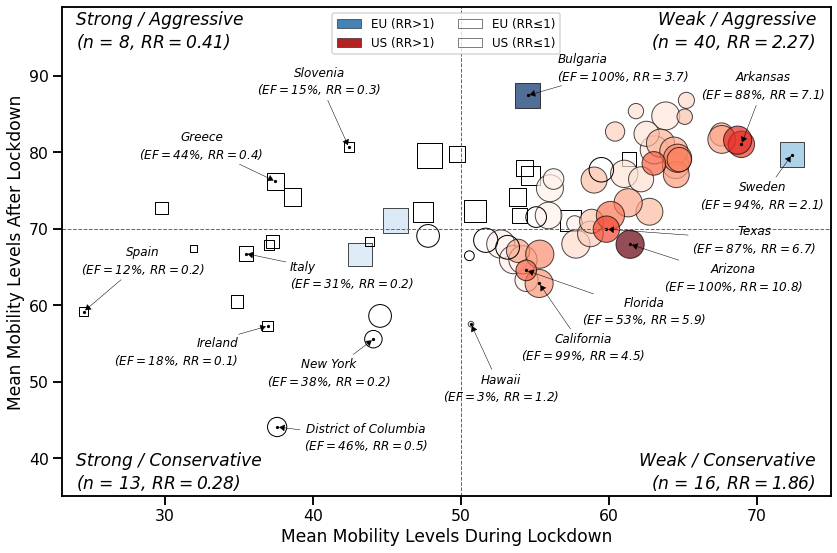

In [38]:
sns.set_context('talk', font_scale=.95)

fig, ax = plt.subplots(figsize=(12, 8))



# Colour maps for the EU & US
eu_cmap = plt.cm.Blues
eu_norm = matplotlib.colors.Normalize(vmin=1)
eu_sm = plt.cm.ScalarMappable(cmap=eu_cmap, norm=eu_norm)

us_cmap = plt.cm.Reds
us_norm = matplotlib.colors.Normalize(vmin=1)
us_sm = plt.cm.ScalarMappable(cmap=us_cmap, norm=us_norm)

eu_colours = eu_cmap(eu_norm(eu_us_features[in_eu & increasing_rebounds]['rebound_ratio_cases']))
us_colours = us_cmap(us_norm(eu_us_features[in_us & increasing_rebounds]['rebound_ratio_cases']))


# --- THE MAIN SCATTER PLOTS
size_scale = 1.45
square_adj = .8

# The increasing rebounds
ax.scatter(eu_us_features[in_eu & increasing_rebounds]['lockdown_mean_mobility_level']*100, eu_us_features[in_eu & increasing_rebounds]['rebound_mean_mobility_level']*100, 
           s=eu_us_features[in_eu & increasing_rebounds]['lockdown_exit_level_cases']*100**size_scale*square_adj, 
           marker='s', edgecolor='k', lw=1, label='US', color=eu_colours, alpha=.7)

ax.scatter(eu_us_features[in_eu & ~increasing_rebounds]['lockdown_mean_mobility_level']*100, eu_us_features[in_eu & ~increasing_rebounds]['rebound_mean_mobility_level']*100, 
           s=eu_us_features[in_eu & ~increasing_rebounds]['lockdown_exit_level_cases']*100**size_scale*square_adj, 
           marker='s', edgecolor='k', lw=1, color='none')


ax.scatter(eu_us_features[in_us & increasing_rebounds]['lockdown_mean_mobility_level']*100, eu_us_features[in_us & increasing_rebounds]['rebound_mean_mobility_level']*100, 
           s=eu_us_features[in_us & increasing_rebounds]['lockdown_exit_level_cases']*100**size_scale, 
           marker='o', edgecolor='k', lw=1, label='US', color=us_colours, alpha=.7)

ax.scatter(eu_us_features[in_us & ~increasing_rebounds]['lockdown_mean_mobility_level']*100, eu_us_features[in_us & ~increasing_rebounds]['rebound_mean_mobility_level']*100, 
           s=eu_us_features[in_us & ~increasing_rebounds]['lockdown_exit_level_cases']*100**size_scale, 
           marker='o', edgecolor='k', lw=1, color='none')



# --- ANNOTATIONS

# The rebound ratios converted to % increase/decrease
rebound_ratios_by_quadrant = ((eu_us_features.groupby(
    ['is_strong_lockdown', 'is_conservative_rebound'])['rebound_ratio_cases'].median()))

frac_pos_rebounds_by_quadrant = eu_us_features.groupby(
    ['is_strong_lockdown', 'is_conservative_rebound'])['is_increasing_rebound'].mean()

n_by_quadrant = eu_us_features.groupby(
    ['is_strong_lockdown', 'is_conservative_rebound'])['is_increasing_rebound'].size()

# A label helper
def add_arrow(n): 
    label = '↑{}'.format(int(n)) if n>0 else '↓{}'.format(int(abs(n)))
    return label

strong_aggressive_label = 'Strong / Aggressive\n(n = {}, $RR=${:.2f})'.format(
    n_by_quadrant.loc[True].loc[False], rebound_ratios_by_quadrant.loc[True].loc[False])


strong_conservative_label = 'Strong / Conservative\n(n = {}, $RR=${:.2f})'.format(
    n_by_quadrant.loc[True].loc[True], rebound_ratios_by_quadrant.loc[True].loc[True])


weak_aggressive_label = 'Weak / Aggressive\n(n = {}, $RR=${:.2f})'.format(
    n_by_quadrant.loc[False].loc[False], rebound_ratios_by_quadrant.loc[False].loc[False])


weak_conservative_label = 'Weak / Conservative\n(n = {}, $RR=${:.2f})'.format(
    n_by_quadrant.loc[False].loc[True], rebound_ratios_by_quadrant.loc[False].loc[True])



# Need to set the axis limits before plotting the labels
ax.set_xlim(23, 75)
ax.set_ylim(35, 99)

ax.text(ax.get_xlim()[0]+1, ax.get_ylim()[1]-.5, strong_aggressive_label, style='italic', ha='left', va='top')
ax.text(ax.get_xlim()[0]+1, ax.get_ylim()[0]+.5, strong_conservative_label, style='italic', ha='left', va='bottom')
ax.text(ax.get_xlim()[1]-1, ax.get_ylim()[1]-.5, weak_aggressive_label, style='italic', ha='right', va='top')
ax.text(ax.get_xlim()[1]-1, ax.get_ylim()[0]+.5, weak_conservative_label, style='italic', ha='right', va='bottom')

# Highlight specific states
highlights = [
    ('District of Columbia', 3, -3, 'center'), 
    ('New York', -6, -6, 'center'),
    ('Arkansas', -1.5, 6, 'center'),
    ('Arizona', 4, -6, 'center'),
    ('Texas', 7, -3, 'center'),
    ('California', 0, -10, 'center'),
    ('Hawaii', -1, -10, 'center'),
    ('Florida', 5, -7, 'center'),
    
    ('Ireland', -5, -5, 'right'),
    ('Spain', 1, 5, 'center'),
    ('Italy', 0, -4.5, 'left'),
    ('Sweden', -5, -7, 'center'),

    ('Slovenia', -5, 7, 'center'),
    ('Bulgaria', -1, 2, 'left'),
    ('Greece', -8, 3, 'center'),
]

for highlight, x_offset, y_offset, ha, in highlights:
    state = eu_us_features.loc[highlight]
    x, y = state['lockdown_mean_mobility_level']*100, state['rebound_mean_mobility_level']*100
    label = '{}\n($EF=${}%, $RR=${:.1f})'.format(
        highlight, 
        int(100*eu_us_features.loc[highlight]['lockdown_exit_level_cases']), 
        (eu_us_features.loc[highlight]['rebound_ratio_cases'])
    )
    
    ax.annotate(
        label, xy=(x, y), xytext=(x+3+x_offset, y+y_offset), ha=ha,
        arrowprops=dict(facecolor='k', arrowstyle='-|>, head_width=.25', lw=.5), fontsize=12, style='italic',
    )
    
    ax.scatter([x], [y], s=3, marker='o', color='k')


# The separating lines
ax.axvline(strong_threshold*100, lw=1, ls='--', c='dimgrey')
ax.axhline(conservative_threshold*100, lw=1, ls='--', c='dimgrey')

ax.set_xlabel('Mean Mobility Levels During Lockdown')
ax.set_ylabel('Mean Mobility Levels After Lockdown')

# Build the Legend
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='k',lw=.5, label='EU (RR>1)'),
    Patch(facecolor='firebrick', edgecolor='k',lw=.5, label='US (RR>1)'),
    Patch(facecolor='none', edgecolor='k',lw=.5, label='EU (RR≤1)'),
    Patch(facecolor='none', edgecolor='k',lw=.5, label='US (RR≤1)'),
]

ax.legend(handles=legend_elements, ncol=2, loc='upper center', frameon=True, fontsize=12)


fig.tight_layout()


fig.savefig('../graphs/eu_us_scatter.png', **fig_params)

logger.info('Saving chart -> %s' % '../graphs/eu_us_scatter.png')

In [39]:
eu_us_features.groupby('is_strong_lockdown').apply(lambda g: (~g['is_increasing_rebound']).mean())

is_strong_lockdown
False    0.214286
True     0.904762
dtype: float64

In [40]:
eu_us_features.groupby('is_strong_lockdown')['lockdown_days_from_peak_cases'].mean()

is_strong_lockdown
False    10.000000
True     24.142857
Name: lockdown_days_from_peak_cases, dtype: float64

In [41]:
rpy.ttest(eu_us_features[in_eu]['lockdown_mean_mobility_level'], eu_us_features[in_us]['lockdown_mean_mobility_level'])

(                       Variable     N      Mean        SD        SE  \
 0  lockdown_mean_mobility_level  26.0  0.452686  0.109288  0.021433   
 1  lockdown_mean_mobility_level  51.0  0.584636  0.066016  0.009244   
 2                      combined  77.0  0.540082  0.103640  0.011811   
 
    95% Conf.  Interval  
 0   0.408544  0.496828  
 1   0.566069  0.603204  
 2   0.516558  0.563605  ,
                                   Independent t-test  results
 0  Difference (lockdown_mean_mobility_level - loc...  -0.1320
 1                              Degrees of freedom =   75.0000
 2                                               t =   -6.5983
 3                           Two side test p value =    0.0000
 4                          Difference < 0 p value =    0.0000
 5                          Difference > 0 p value =    1.0000
 6                                       Cohen's d =   -1.5900
 7                                       Hedge's g =   -1.5741
 8                                   G

In [42]:
rpy.ttest(eu_us_features[in_eu]['rebound_mean_mobility_level'], eu_us_features[in_us]['rebound_mean_mobility_level'])

(                      Variable     N      Mean        SD        SE  95% Conf.  \
 0  rebound_mean_mobility_level  26.0  0.722411  0.071044  0.013933   0.693715   
 1  rebound_mean_mobility_level  51.0  0.728373  0.086633  0.012131   0.704007   
 2                     combined  77.0  0.726360  0.081277  0.009262   0.707912   
 
    Interval  
 0  0.751106  
 1  0.752739  
 2  0.744808  ,
                                   Independent t-test  results
 0  Difference (rebound_mean_mobility_level - rebo...  -0.0060
 1                              Degrees of freedom =   75.0000
 2                                               t =   -0.3026
 3                           Two side test p value =    0.7630
 4                          Difference < 0 p value =    0.3815
 5                          Difference > 0 p value =    0.6185
 6                                       Cohen's d =   -0.0729
 7                                       Hedge's g =   -0.0722
 8                                   Glass

In [43]:
eu_us_features.groupby(['region', 'is_strong_lockdown', 'is_conservative_rebound']).size().unstack()

is_conservative_rebound    False  True 
region is_strong_lockdown              
eu     False                 9.0    NaN
       True                  8.0    9.0
us     False                31.0   16.0
       True                  NaN    4.0

In [44]:
eu_us_features.groupby(['is_strong_lockdown']).size()/len(eu_us_features)

is_strong_lockdown
False    0.727273
True     0.272727
dtype: float64

In [45]:
(eu_us_features.groupby(['region', 'is_strong_lockdown']).size()/eu_us_features.groupby(['region']).size()).unstack()

is_strong_lockdown     False     True 
region                                
eu                  0.346154  0.653846
us                  0.921569  0.078431

In [46]:
eu_us_features.groupby('region')[['lockdown_mean_mobility_level', 'rebound_mean_mobility_level']].mean()

lockdown_mean_mobility_level  rebound_mean_mobility_level
region                                                           
eu                          0.452686                     0.722411
us                          0.584636                     0.728373

In [47]:
ttest_ind(eu_us_features[in_eu]['lockdown_mean_mobility_level'], eu_us_features[in_us]['lockdown_mean_mobility_level']), ttest_ind(eu_us_features[in_eu]['rebound_mean_mobility_level'], eu_us_features[in_us]['rebound_mean_mobility_level'])

(Ttest_indResult(statistic=-6.598273592594042, pvalue=5.205554661852089e-09),
 Ttest_indResult(statistic=-0.3026075612306276, pvalue=0.7630266303980532))